Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
## DROP_N=675 => 31/10/2021
#
drop_n_dataset_days=675
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/12/22  8/13/22  8/14/22  \
185        0        0        0        0  ...      307      307      307   
186        0        0        0        0  ...      739      739      739   
187        0        0        0        0  ...      797      797      797   
188        0        0        0        0  ...        2        2        2   
189        0        0        0        0  ...      992      992      992   
190        0        0        0        0  ...     1019     1019     1019   
191        0        0        0        0  ...   328437   328724   328732   
192        0        0        0        0  ...       19       19       19   
193        0        0        0        0  ...    11662    11662    11662   
194        0        0        0        0  ...       61       61       61   

     8/15/22  8/16/22  8/17/22  8/18/22  8/19/22   Population   \
185      307      307      307      307      307       540,544   
186      739      739      739      739      739    20,250,833   
187      797      797      798      798      799       441,543   
188        2        6        9       11       13           NaN   
189      992      992      992      992      992     4,649,658   
190     1019     1019     1019     1019     1020     1,273,985   
191   328736   328798   328871   328871   328871   128,640,794   
192       19       21       21       21       21           NaN   
193    11662    11693    11693    11693    11693     4,035,942   
194       61       61       61       61       61        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 947 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/12/22  8/13/22  8/14/22  \
175        0        0        0        0  ...        0        0        0   
176        0        0        0        0  ...        0        0        0   
177        0        0        0        0  ...        0        0        0   
178        0        0        0        0  ...        0        0        0   
179        0        0        0        0  ...        0        0        0   
180        0        0        0        0  ...        0        0        0   
181        0        0        0        0  ...        0        0        0   
182        0        0        0        0  ...        0        0        0   
183        0        0        0        0  ...        0        0        0   
184        0        0        0        0  ...        0        0        0   

     8/15/22  8/16/22  8/17/22  8/18/22  8/19/22   Population   \
175        0        0        0        0        0           NaN   
176        0        0        0        0        0     4,035,942   
177        0        0        0        0        0        39,183   
178        0        0        0        0        0     3,278,290   
179        0        0        0        0        0       622 500   
180        0        0        0        0        0    36,817,128   
181        0        0        0        0        0    31,542,919   
182        0        0        0        0        0     2,540,905   
183        0        0        0        0        0    29,300,000   
184        0        0        0        0        0       116,600   

                region  
175     Micronesia_nan  
176        Moldova_nan  
177         Monaco_nan  
178       Mongolia_nan  
179     Montenegro_nan  
180        Morocco_nan  
181     Mozambique_nan  
182        Namibia_nan  
183          Nepal_nan  
184  Netherlands_Aruba  

[10 rows x 947 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  8/12/22  8/13/22  8/14/22  \
185        0        0        0        0  ...   184591   184591   184591   
186        0        0        0        0  ...    31242    31244    31245   
187        0        0        0        0  ...   113471   113501   113534   
188        0        0        0        0  ...      681      681     1250   
189        0        0        0        0  ...    62701    62705    62708   
190        0        0        0        0  ...   248720   248720   248720   
191        0        0        0        0  ...  6875708  6925668  6927636   
192        0        0        0        0  ...     7139     7139     7139   
193        0        0        0        0  ...   551862   551862   551862   
194        0        0        0        0  ...    14277    14277    14277   

     8/15/22  8/16/22  8/17/22  8/18/22  8/19/22   Population   \
185   184689   184689   184689   184689   184689       540,544   
186    31245    31249    31249    31255    31257    20,250,833   
187   113558   113585   113627   113693   113721       441,543   
188     3036     5468     6606     8197     9077           NaN   
189    62717    62721    62724    62726    62726     4,649,658   
190   251746   251746   251746   251746   254400     1,273,985   
191  6929003  6939755  6949653  6949653  6949653   128,640,794   
192     7168     7174     7196     7198     7202           NaN   
193   551862   561196   561196   561196   561196     4,035,942   
194    14277    14277    14299    14299    14309        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 947 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   8/12/22  \
220        0        0        0        0        0        0  ...   3823084   
221        0        0        0        0        0        0  ...   6113843   
222        0        0        0        0        0        0  ...   5376433   
223        0        0        0        0        0        0  ...    418039   
224        0        0        0        0        0        0  ...   3150037   
225        0        0        0        0        0        0  ...  18550522   
226        0        0        0        0        0        0  ...    132343   
227        0        0        0        0        0        0  ...      6485   
228        0        0        0        0        0        0  ...     28341   
229        0        0        0        0        0        0  ...      9404   

      8/13/22   8/14/22   8/15/22   8/16/22   8/17/22   8/18/22   8/19/22  \
220   3827758   3831941   3835422   3838062   3840943   3844708   3848449   
221   6118482   6119257   6120028   6120834   6128006   6133274   6138093   
222   5376433   5376433   5376433   5381599   5385702   5388758   5391747   
223    418622    419370    420143    420895    421532    422130    422686   
224   3154721   3157372   3159626   3163226   3170726   3176211   3181065   
225  18578731  18607284  18632165  18655654  18688416  18723731  18760762   
226    132354    132357    132362    132367    132370    132376    132385   
227      6485      6492      6492      6493      6493      6493      6495   
228     28341     28341     28341     28341     28379     28461     28542   
229      9404      9404      9404      9405      9405      9412      9412   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 947 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

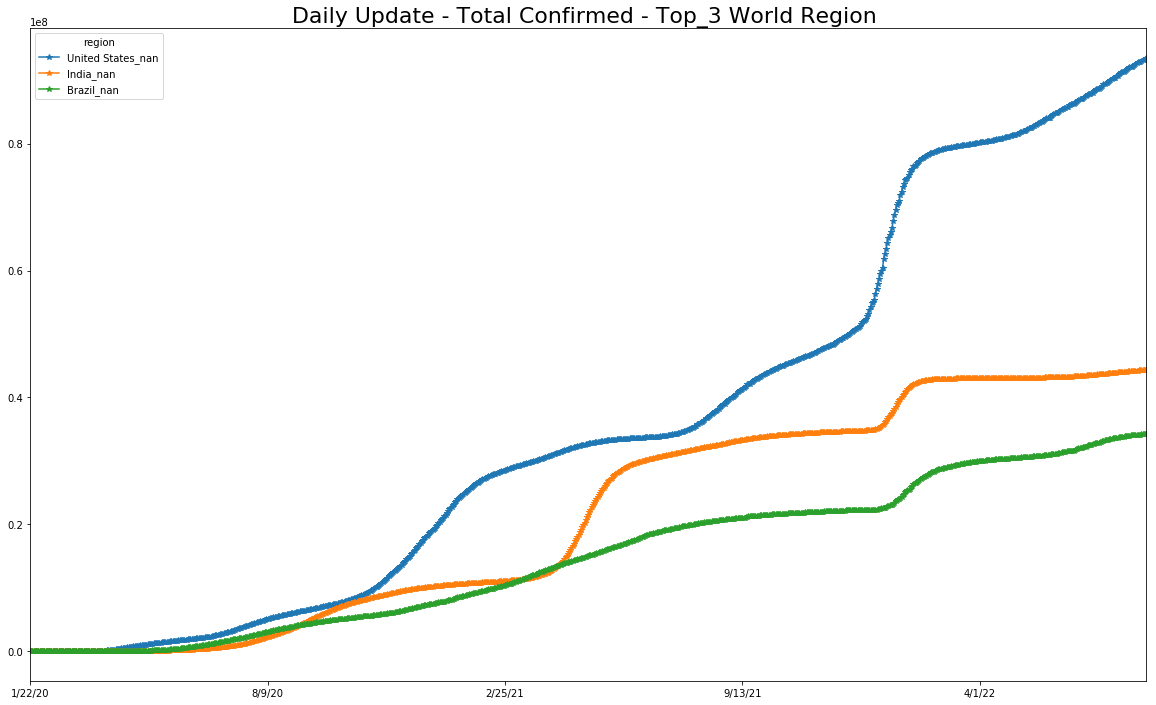

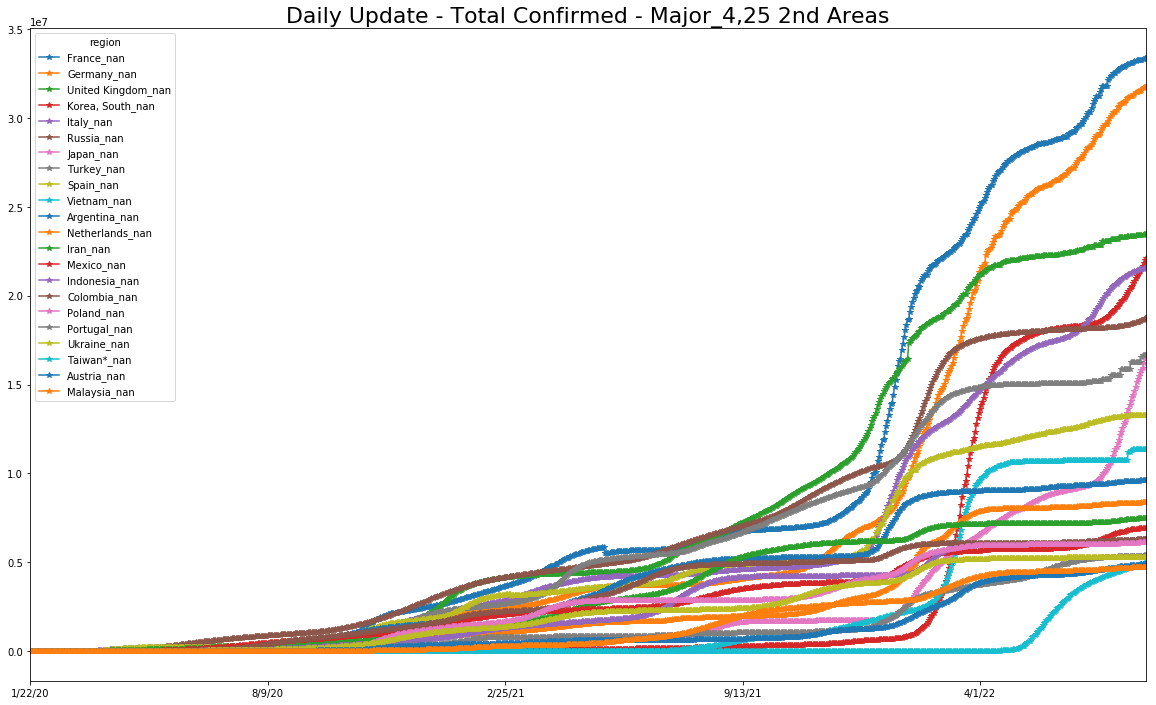

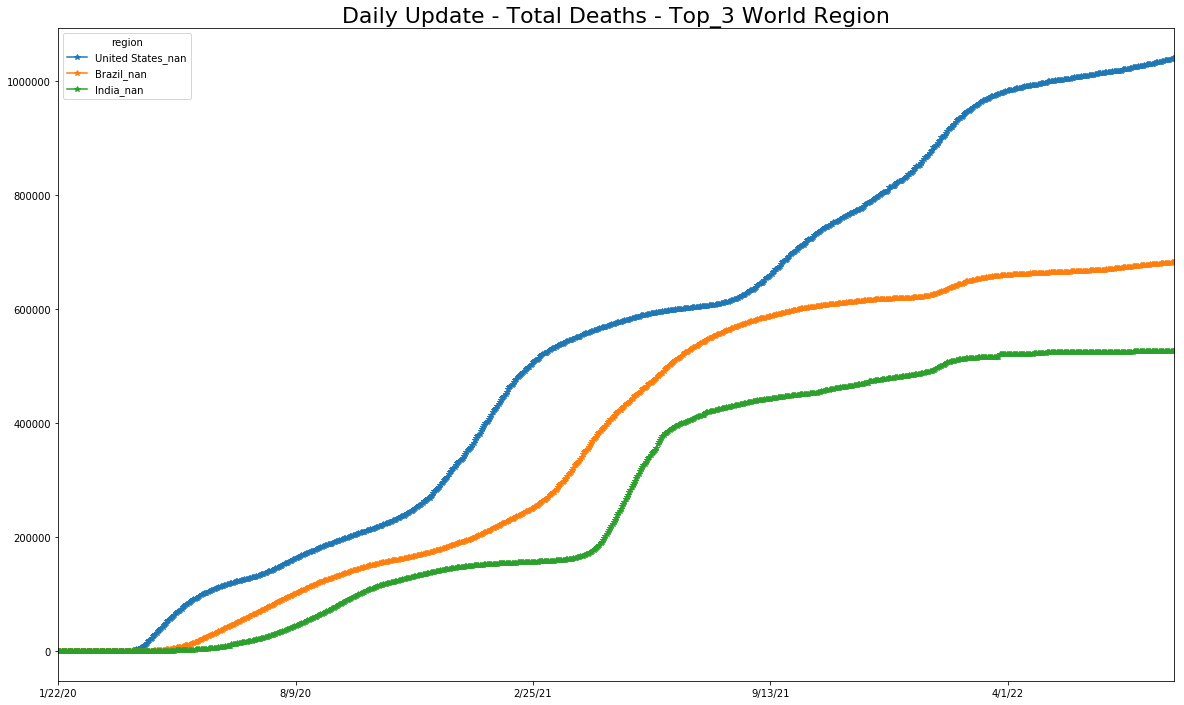

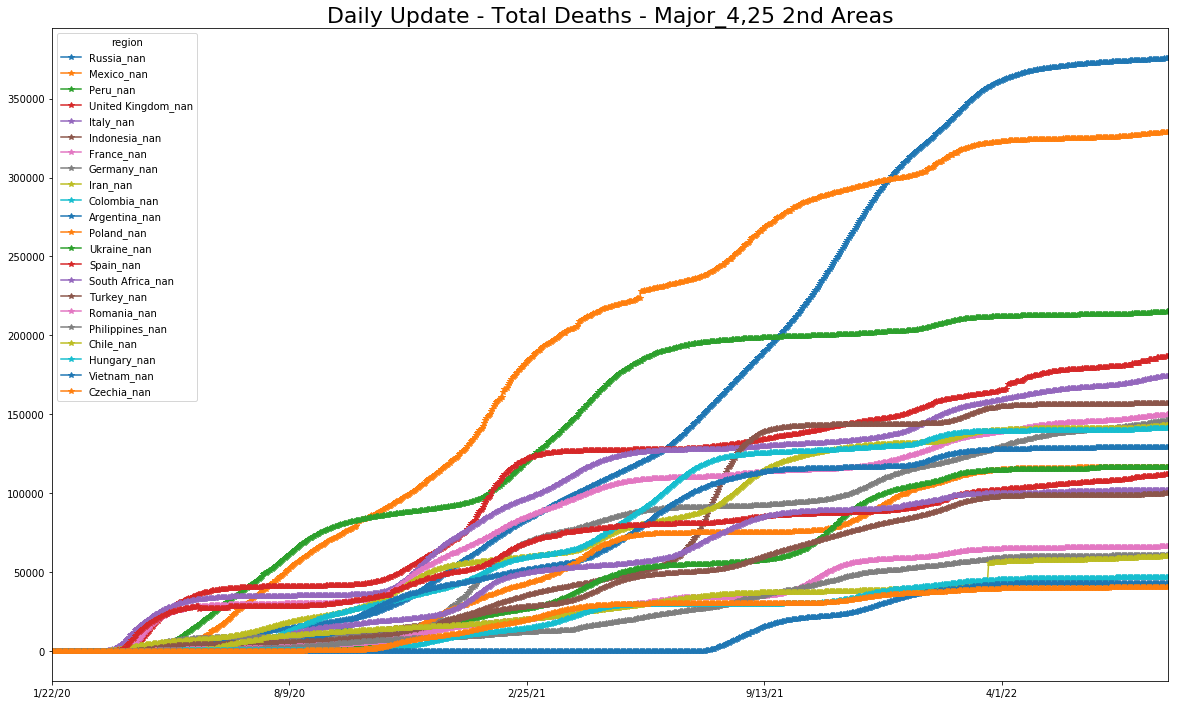

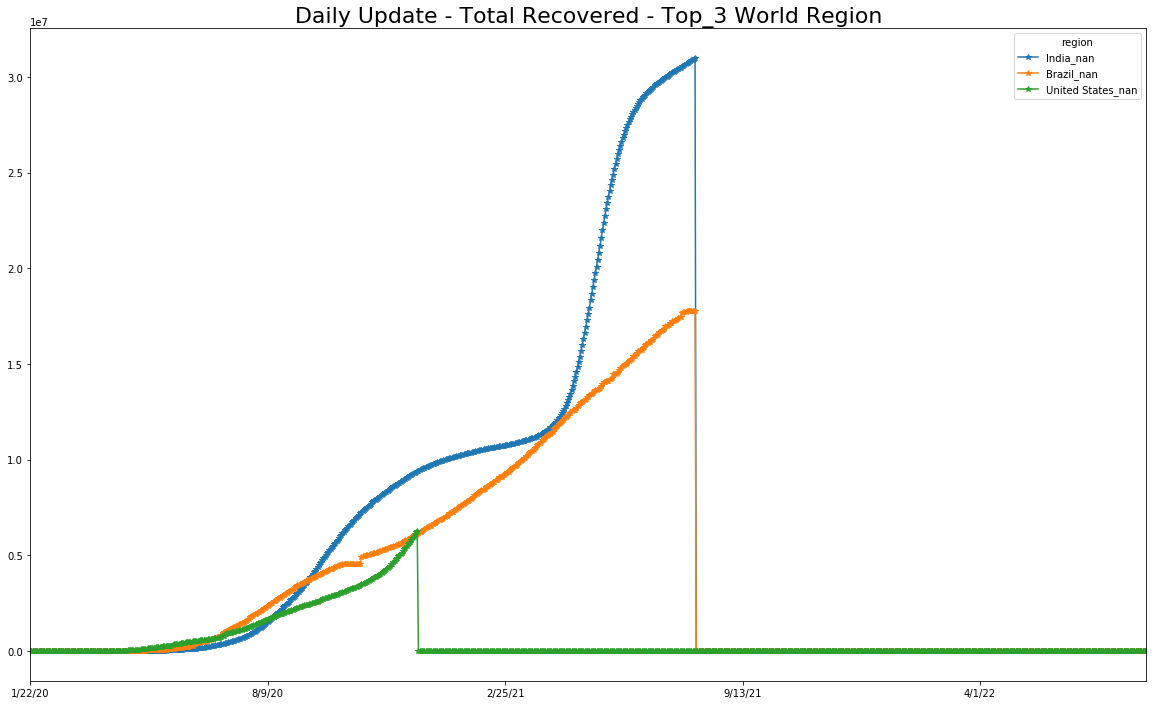

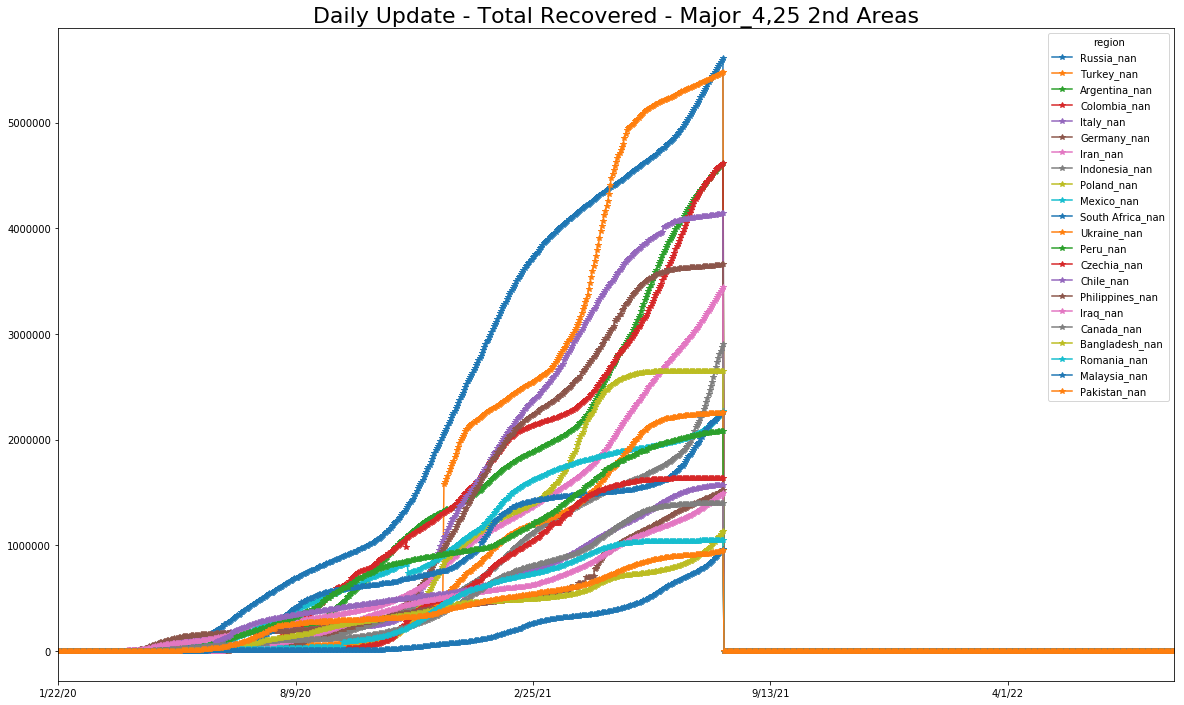

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/08/20


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/27/21           157190       199137       209980        16712       65139   
11/28/21           157218       199555       210152        16712       65144   
11/29/21           157260       199750       210344        16712       65155   

region    Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/27/21               0                     4141        5325560       337522   
11/28/21               0                     4141        5326448       337931   
11/29/21               0                     4141        5328416       338120   

region    Australia_Australian Capital Territory  ...  Uruguay_nan  \
11/27/21                                    2117  ...       399181   
11/28/21                                    2124  ...       399348   
11/29/21                                    2130  ...       399504   

region    Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
11/27/21          192599            6         430046      1197404   
11/28/21          192831            6         430696      1210340   
11/29/21          193065            6         431296      1224110   

region    West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
11/27/21                  459479                         0       9981   
11/28/21                  459479                         0       9987   
11/29/21                  460053                         0       9995   

region    Zambia_nan  Zimbabwe_nan  
11/27/21      210138        133836  
11/28/21      210143        133951  
11/29/21      210150        134226  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
8/16/22           189477       322837       269381        45899      102636   
8/17/22           189710       323282       269473        45975      102636   
8/18/22           190010       323829       269556        45975      102636   
8/19/22           190254       325241       269650        45975      102636   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
8/16/22              11                     8851        9633732       430361   
8/17/22              11                     8851        9633732       430361   
8/18/22              11                     8895        9633732       430361   
8/19/22              11                     8895        9633732       430361   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
8/16/22                                  199292  ...       975264   
8/17/22                                  199673  ...       975264   
8/18/22                                  199919  ...       975264   
8/19/22                                  199919  ...       975264   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
8/16/22          243586        11753         540681     11370462   
8/17/22          243605        11753         540796     11373276   
8/18/22          243623        11753         540796     11376571   
8/19/22          243638        11770         540977     11379554   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
8/16/22                  697447                       535      11903   
8/17/22                  697447                       535      11903   
8/18/22                  697447                       535      11914   
8/19/22                  697447                       535      11915   

region   Zambia_nan  Zimbabwe_nan  
8/16/22      332014        256561  
8/17/22      332264        256565  
8/18/22      332264        256579  
8/19/22      332264        256596  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-11-28  Afghanistan_nan     157218             0             0   
2     2021-11-29  Afghanistan_nan     157260            28             0   
3     2021-11-30  Afghanistan_nan     157289            42             0   
4     2021-12-01  Afghanistan_nan     157359            29            99   
5     2021-12-02  Afghanistan_nan     157387            70           141   
6     2021-12-03  Afghanistan_nan     157412            28           127   
7     2021-12-04  Afghanistan_nan     157431            25           123   
8     2021-12-05  Afghanistan_nan     157454            19            72   
9     2021-12-06  Afghanistan_nan     157499            23            67   
10    2021-12-07  Afghanistan_nan     157508            45            87   
11    2021-12-08  Afghanistan_nan     157542             9            77   
12    2021-12-09  Afghanistan_nan     157585            34            88   
13    2021-12-10  Afghanistan_nan     157603            43            86   
14    2021-12-11  Afghanistan_nan     157611            18            95   
15    2021-12-12  Afghanistan_nan     157633             8            69   
16    2021-12-13  Afghanistan_nan     157648            22            48   
17    2021-12-14  Afghanistan_nan     157660            15            45   
18    2021-12-15  Afghanistan_nan     157665            12            49   
19    2021-12-16  Afghanistan_nan     157725             5            32   
20    2021-12-17  Afghanistan_nan     157734            60            77   
21    2021-12-18  Afghanistan_nan     157745             9            74   
22    2021-12-19  Afghanistan_nan     157787            11            80   
23    2021-12-20  Afghanistan_nan     157797            42            62   
24    2021-12-21  Afghanistan_nan     157816            10            63   
25    2021-12-22  Afghanistan_nan     157841            19            71   
26    2021-12-23  Afghanistan_nan     157878            25            54   
27    2021-12-24  Afghanistan_nan     157887            37            81   
28    2021-12-25  Afghanistan_nan     157895             9            71   
29    2021-12-26  Afghanistan_nan     157951             8            54   
30    2021-12-27  Afghanistan_nan     157967            56            73   
...          ...              ...        ...           ...           ...   
77667 2022-07-22     Zimbabwe_nan     256217            30           134   
77668 2022-07-23     Zimbabwe_nan     256246             0            30   
77669 2022-07-24     Zimbabwe_nan     256254            29            59   
77670 2022-07-25     Zimbabwe_nan     256270             8            37   
77671 2022-07-26     Zimbabwe_nan     256284            16            53   
77672 2022-07-27     Zimbabwe_nan     256315            14            38   
77673 2022-07-28     Zimbabwe_nan     256336            31            61   
77674 2022-07-29     Zimbabwe_nan     256376            21            66   
77675 2022-07-30     Zimbabwe_nan     256376            40            92   
77676 2022-07-31     Zimbabwe_nan     256378             0            61   
77677 2022-08-01     Zimbabwe_nan     256382             2            42   
77678 2022-08-02     Zimbabwe_nan     256403             4             6   
77679 2022-08-03     Zimbabwe_nan     256423            21            27   
77680 2022-08-04     Zimbabwe_nan     256444            20            45   
77681 2022-08-05     Zimbabwe_nan     256444            21            62   
77682 2022-08-06     Zimbabwe_nan     256444             0            41   
77683 2022-08-07     Zimbabwe_nan     256447             0            21   
77684 2022-08-08     Zimbabwe_nan     256487             3             3   
77685 2022-08-09     Zimbabwe_nan     256490            40            43   
77686 2022-08-10     Zimbabwe_nan     256492             3            46   
77687 2022-08-11     Zimbabwe_nan     256513             2  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
77696 2022-08-20  Zimbabwe_nan          0            17            35   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
77696            74          100.00663         100.013646         100.028851   

       last_day  kalman_prediction  population  infected_rate  min  max  
77696    256596           256603.0    14862924       0.000173  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
77696 2022-08-20  Zimbabwe_nan          0            17            35   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
77696            74          100.00663         100.013646         100.028851   

       last_day  kalman_prediction  population  infected_rate  min  max  
77696    256596           256603.0    14862924       0.000173  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
76092  2022-08-18  Zimbabwe_nan     256579             4            26   
76093  2022-08-19  Zimbabwe_nan     256596            14            35   
76094  2022-08-20  Zimbabwe_nan          0            17            35   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
76092            73         100.001563         100.010139         100.028465   
76093            66         100.005461         100.013647         100.025734   
76094            74         100.006630         100.013646         100.028851   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
76092               256565  ...    14862924       0.000173  NaN  NaN   
76093               256579  ...    14862924       0.000173  NaN  NaN   
76094               256596  ...    14862924       0.000173  NaN  NaN   

       population_percentage : infected_rate confirmed  \
76092                                         0.017262   
76093                                         0.017263   
76094                                         0.017264   

       population_percentage : factor 9/10 infected_rate confirmed  \
76092                                           0.155359             
76093                                           0.155368             
76094                                           0.155378             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
76092                    12.0                           0.807378   
76093                     9.0                           0.605534   
76094                     7.0                           0.470971   

       delta : roling 7day AVG  \
76092                10.428571   
76093                 9.428571   
76094                10.571429   

       delta : aprox 14-day case notification rate per 100k hab  
76092                                           0.982310         
76093                                           0.888116         
76094                                           0.995766         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
274  United States_nan  3.318351e+13  5.760513e+06  483904.12782


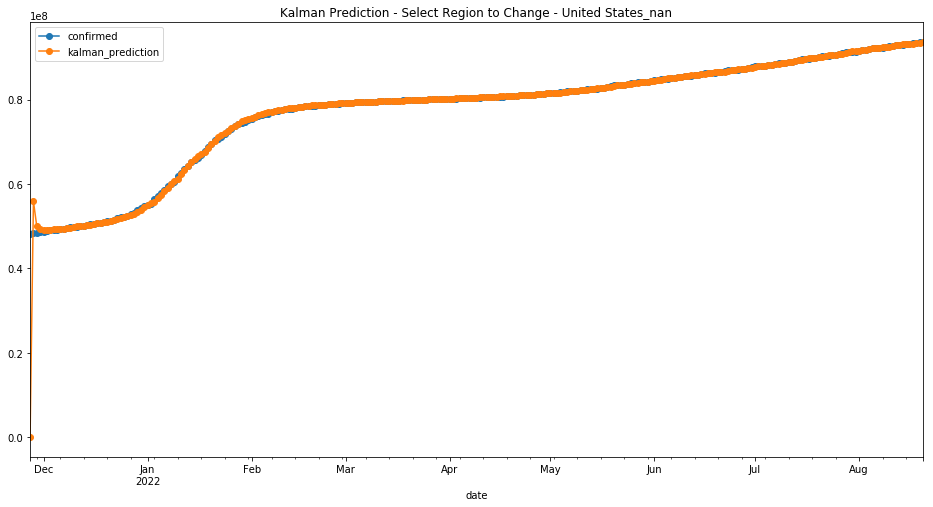

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.335375e+12  1.155584e+06  89307.345865


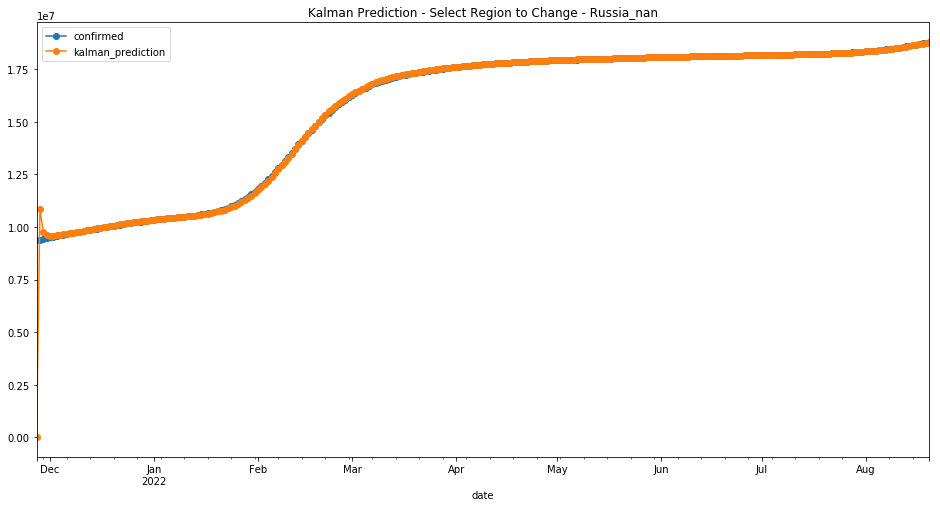

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  4.469208e+12  2.114050e+06  174893.793233


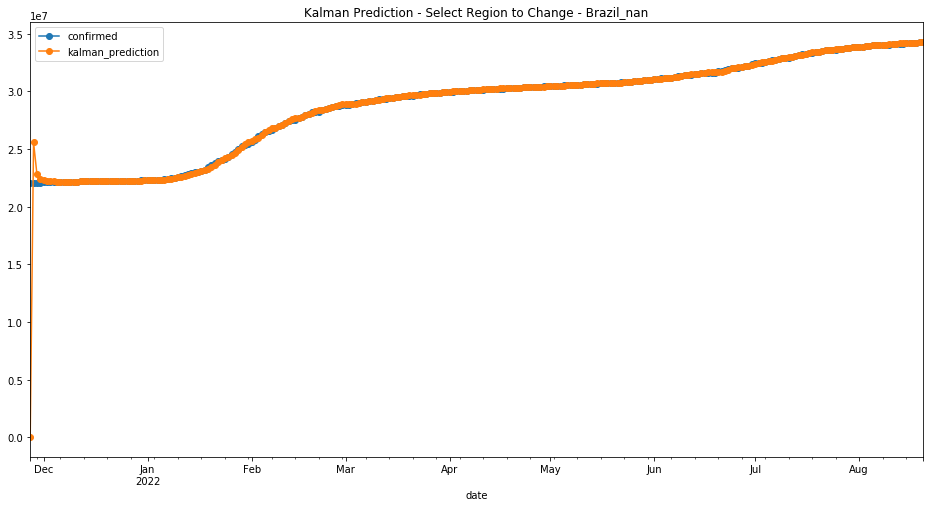

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
273  United Kingdom_nan  2.085646e+12  1.444177e+06  133178.18797


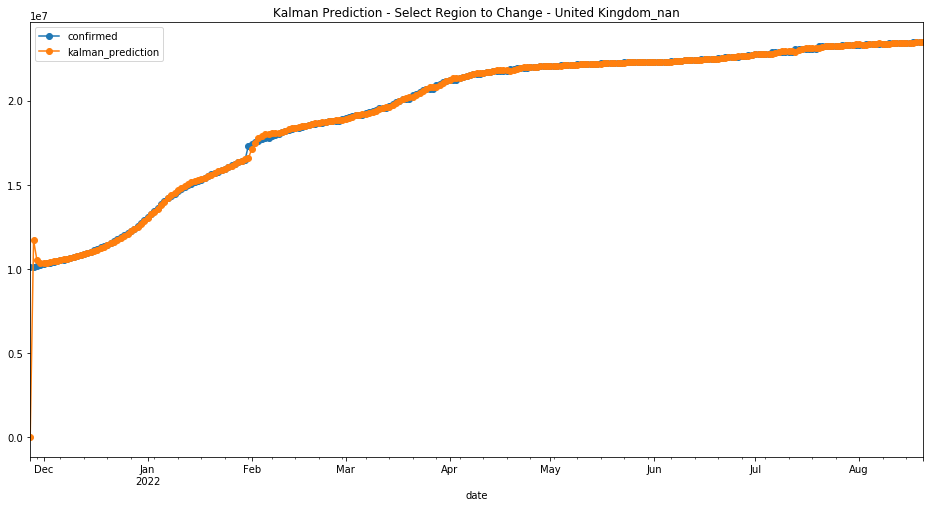

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnxo2xso8
  JVM stdout: /tmp/tmpnxo2xso8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnxo2xso8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         04 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 9 months and 24 days !!!
H2O cluster name:           H2O_from_python_unknownUser_vlurgz
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-08-12
last_train_date= 2022-08-19
first_bootstrap_date= 2022-08-11
boost_bootstrap_date= 2022-08-16
first_test_date= 2022-08-10
last_test_date= 2022-08-20
first_valid_date= 2022-08-18


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   190564.0     188506 2022-08-11  Afghanistan_nan
1   190846.0     188704 2022-08-12  Afghanistan_nan
2   191100.0     188820 2022-08-13  Afghanistan_nan
3   191257.0     189045 2022-08-14  Afghanistan_nan
4   191427.0     189343 2022-08-15  Afghanistan_nan
5   191662.0     189477 2022-08-16  Afghanistan_nan
6   191864.0     189710 2022-08-17  Afghanistan_nan
7   192056.0     190010 2022-08-18  Afghanistan_nan
8   192311.0     190254 2022-08-19  Afghanistan_nan
9   192579.0          0 2022-08-20  Afghanistan_nan
10  321418.0     320086 2022-08-11      Albania_nan
11  322072.0     320781 2022-08-12      Albania_nan
12  322780.0     321345 2022-08-13      Albania_nan
13  323381.0     321804 2022-08-14      Albania_nan
14  323865.0     322125 2022-08-15      Albania_nan
15  324179.0     322837 2022-08-16      Albania_nan
16  324807.0     323282 2022-08-17      Albania_nan
17  325236.0     323829 2022-08-18      Albania_nan
18  325761.0     325241 2022-08-19      Albania_nan
19  326987.0          0 2022-08-20      Albania_nan
20  270891.0     268718 2022-08-11      Algeria_nan
21  271018.0     268866 2022-08-12      Algeria_nan
22  271161.0     269008 2022-08-13      Algeria_nan
23  271305.0     269141 2022-08-14      Algeria_nan
24  271445.0     269269 2022-08-15      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4884683.0    4881155 2022-08-16     Austria_nan
176  4882327.0    4885051 2022-08-17     Austria_nan
177  4887774.0    4891298 2022-08-18     Austria_nan
178  4895233.0    4898954 2022-08-19     Austria_nan
179  4902995.0          0 2022-08-20     Austria_nan
180   805309.0     803645 2022-08-11  Azerbaijan_nan
181   805604.0     804165 2022-08-12  Azerbaijan_nan
182   806199.0     804585 2022-08-13  Azerbaijan_nan
183   806668.0     805103 2022-08-14  Azerbaijan_nan
184   807236.0     805213 2022-08-15  Azerbaijan_nan
185   807305.0     805762 2022-08-16  Azerbaijan_nan
186   807888.0     806472 2022-08-17  Azerbaijan_nan
187   808578.0     807017 2022-08-18  Azerbaijan_nan
188   809075.0     807516 2022-08-19  Azerbaijan_nan
189   809608.0          0 2022-08-20  Azerbaijan_nan
190    38615.0      36870 2022-08-11     Bahamas_nan
191    38563.0      36881 2022-08-12     Bahamas_nan
192    38594.0      36905 2022-08-13     Bahamas_nan
193    38573.0      36905 2022-08-14     Bahamas_nan
194    38658.0      36932 2022-08-15     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   96373.0      96781 2022-08-11  Barbados_nan
221   96951.0      97104 2022-08-12  Barbados_nan
222   97402.0      97411 2022-08-13  Barbados_nan
223   97732.0      97638 2022-08-14  Barbados_nan
224   98022.0      97846 2022-08-15  Barbados_nan
225   98191.0      98277 2022-08-16  Barbados_nan
226   98323.0      98622 2022-08-17  Barbados_nan
227   98722.0      98958 2022-08-18  Barbados_nan
228   99064.0      99204 2022-08-19  Barbados_nan
229   99400.0          0 2022-08-20  Barbados_nan
230  995538.0     994037 2022-08-11   Belarus_nan
231  995538.0     994037 2022-08-12   Belarus_nan
232  995538.0     994037 2022-08-13   Belarus_nan
233  995538.0     994037 2022-08-14   Belarus_nan
234  995538.0     994037 2022-08-15   Belarus_nan
235  995538.0     994037 2022-08-16   Belarus_nan
236  995538.0     994037 2022-08-17   Belarus_nan
237  995538.0     994037 2022-08-18   Belarus_nan
238  995538.0     994037 2022-08-19   Belarus_nan
239  995538.0          0 2022-08-20   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  219871716829.91046
# MSE on the validation data =  150808560207945.03
# R^2 on the training data =  0.9990411507223697
# R^2 on the validation data =  0.37313663443309486


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1660997608948_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 219871716829.91046
RMSE: 468904.8057227719
MAE: 35159.559609184624
RMSLE: 0.3978288732433269
Mean Residual Deviance: 219871716829.91046

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 150808560207945.03
RMSE: 12280413.682280619
MAE: 4051844.7030446683
RMSLE: 8.736794254843508
Mean Residual Deviance: 150808560207945.03
Scoring History: 


timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2022-08-20 12:13:52  0.374 sec         0                  nan              nan             nan                  nan                nan               nan
    2022-08-20 12:13:54  2.163 sec         1                  360965           67754.8         1.30296e+11          1.23647e+07        4.06754e+06       1.52886e+14
    2022-08-20 12:13:55  2.789 sec         2                  476150           70955           2.26719e+11          1.23618e+07        4.06021e+06       1.52814e+14
    2022-08-20 12:13:56  4.434 sec         3                  473117           68429.3         2.2384e+11           1.21779e+07        4.06011e+06       1.48302e+14
    2022-08-20 12:14:00  8.447 sec         16                 572715           54745.7         3.28002e+11          1.22395e+07        4.05914e+06       1.49805e+14
    2022-08-20 12:14:04  12.528 sec        30                 496615           49127.5         2.46627e+11          1.22611e+07        4.05855e+06       1.50335e+14
    2022-08-20 12:14:09  16.635 sec        46                 489831           45776.9         2.39935e+11          1.22702e+07        4.05762e+06       1.50559e+14
    2022-08-20 12:14:13  20.669 sec        66                 468303           43128.1         2.19307e+11          1.22563e+07        4.05604e+06       1.50217e+14
    2022-08-20 12:14:17  24.749 sec        89                 481625           42831.4         2.31962e+11          1.22663e+07        4.05458e+06       1.50463e+14
    2022-08-20 12:14:21  28.812 sec        118                498149           41417.3         2.48153e+11          1.22733e+07        4.05395e+06       1.50635e+14
    2022-08-20 12:14:25  32.844 sec        153                480852           39778.7         2.31218e+11          1.22761e+07        4.05352e+06       1.50703e+14
    2022-08-20 12:14:29  36.885 sec        191                483341           38893.3         2.33619e+11          1.22797e+07        4.05241e+06       1.5079e+14
    2022-08-20 12:14:33  40.947 sec        235                477398           38157.5         2.27909e+11          1.22737e+07        4.05194e+06       1.50643e+14
    2022-08-20 12:14:37  44.998 sec        283                474641           37447.9         2.25284e+11          1.22742e+07        4.05197e+06       1.50657e+14
    2022-08-20 12:14:41  49.050 sec        336                470761           36161           2.21616e+11          1.22789e+07        4.05192e+06       1.50771e+14
    2022-08-20 12:14:45  53.302 sec        394                475743           35645.3         2.26332e+11          1.22761e+07        4.05141e+06       1.50703e+14
    2022-08-20 12:14:50  58.366 sec        466                468491           35065.1         2.19483e+11          1.22771e+07        4.05185e+06       1.50728e+14
    2022-08-20 12:14:53  1 min  1.075 sec  500                468905           35159.6         2.19872e+11          1.22804e+07        4.05184e+06       1.50809e+14

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  3.44475e+20            1                    0.352698
last_day           2.99112e+20            0.868311             0.306252
region             2.23052e+20            0.647511             0.228376
7_day_change       3.5254e+19             0.102341             0.0360955
3_day_change       2.73438e+19            0.0793781            0.0279965
infected_rate      1.69814e+19            0.0492965            0.0173868
1_day_change       1.57798e+19            0.0458082            0.0161565
3_day_change_rate  6.74066e+18            0.0195679            0.00690157
7_day_change_rate  5.87706e+18            0.0170609            0.00601735
1_day_change_rate  2.07009e+18            0.0060094            0.00211951

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         3.444754e+20           1.000000    0.352698
1           last_day         2.991119e+20           0.868311    0.306252
2             region         2.230516e+20           0.647511    0.228376
3       7_day_change         3.525397e+19           0.102341    0.036096
4       3_day_change         2.734380e+19           0.079378    0.027997
5      infected_rate         1.698145e+19           0.049297    0.017387
6       1_day_change         1.577981e+19           0.045808    0.016156
7  3_day_change_rate         6.740665e+18           0.019568    0.006902
8  7_day_change_rate         5.877061e+18           0.017061    0.006017
9  1_day_change_rate         2.070091e+18           0.006009    0.002120

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


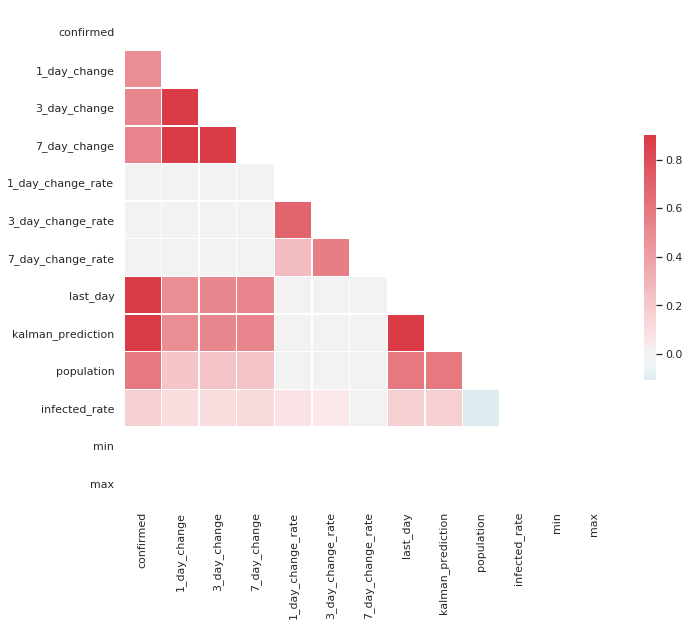

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.488249
3_day_change         0.520171
7_day_change         0.538082
1_day_change_rate    0.017303
3_day_change_rate    0.006719
7_day_change_rate   -0.003575
last_day             0.995450
kalman_prediction    0.996231
population           0.591848
infected_rate        0.169714
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


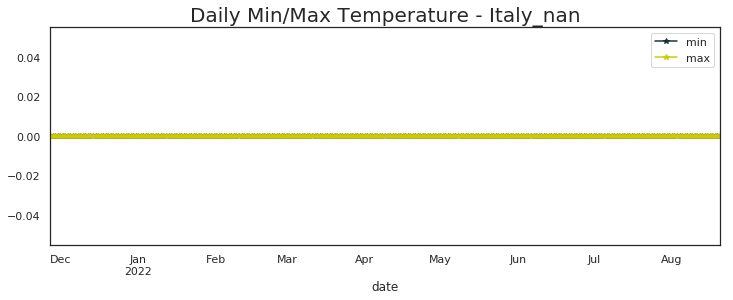

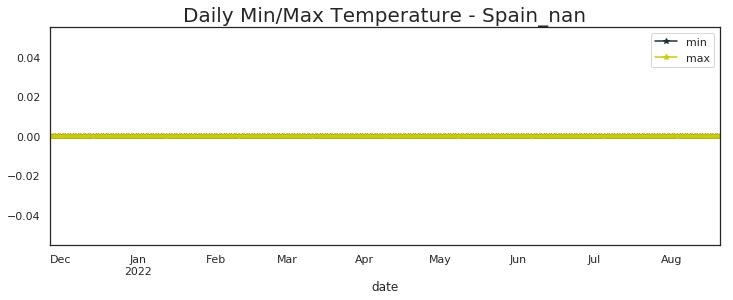

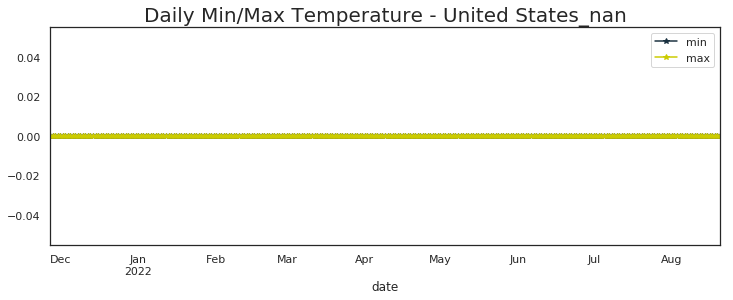

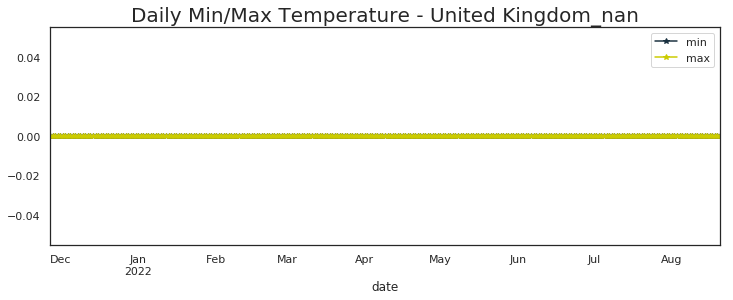

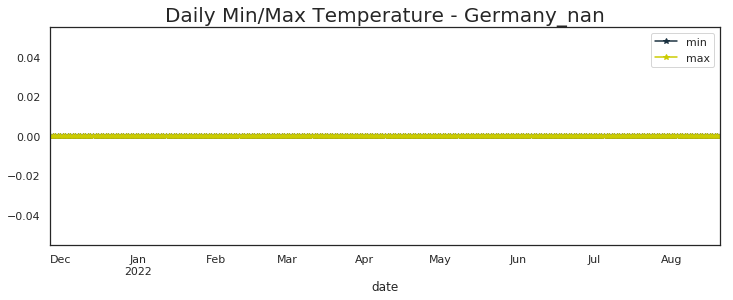

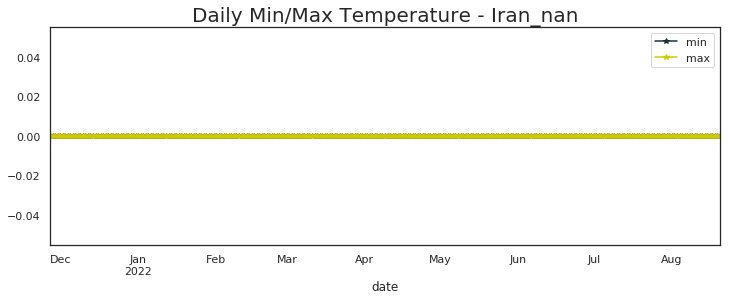

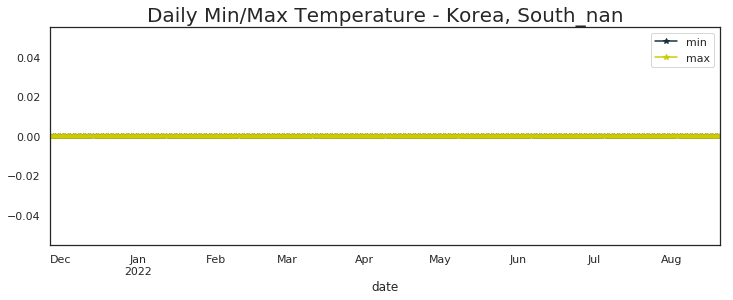

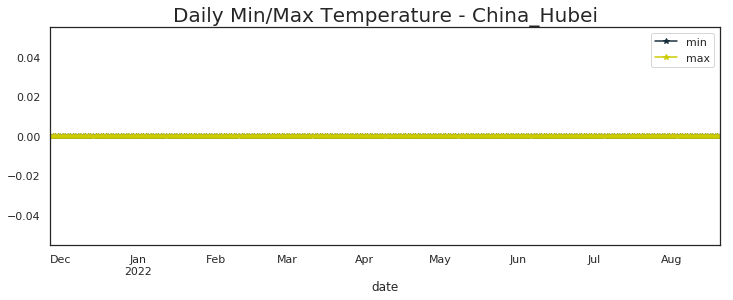

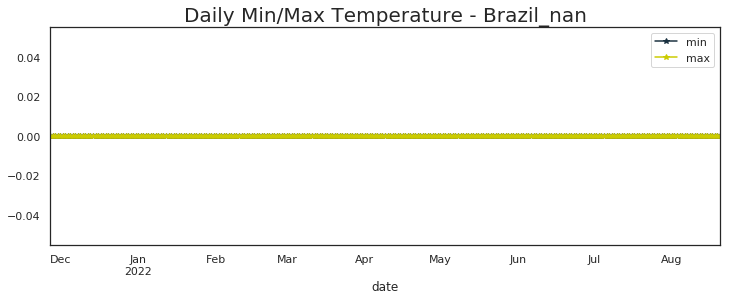

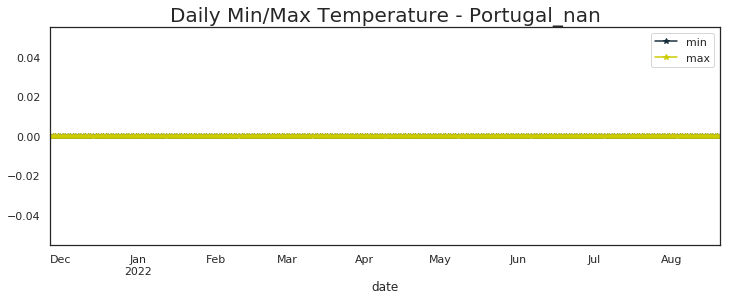

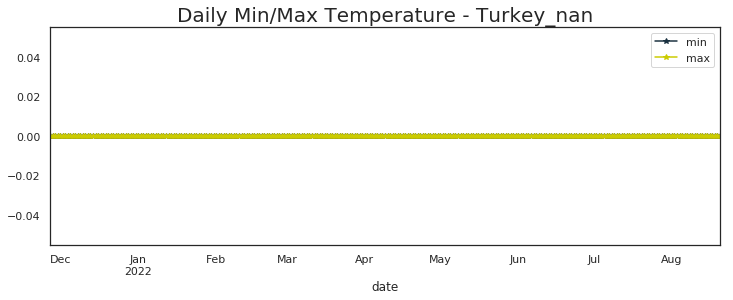

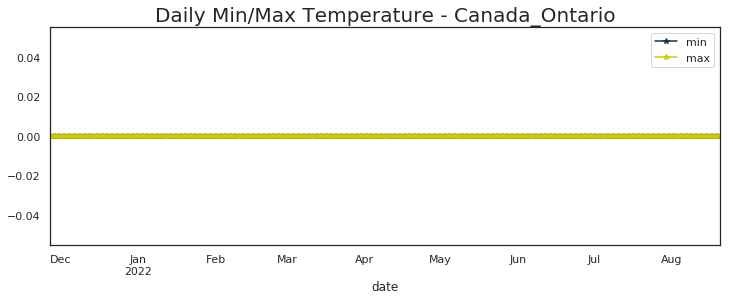

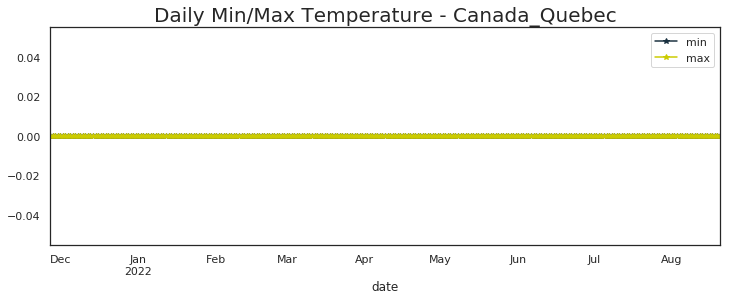

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                           min  max
region                             
United States_nan          0.0  0.0
India_nan                  0.0  0.0
Brazil_nan                 0.0  0.0
France_nan                 0.0  0.0
Germany_nan                0.0  0.0
United Kingdom_nan         0.0  0.0
Korea, South_nan           0.0  0.0
Italy_nan                  0.0  0.0
Russia_nan                 0.0  0.0
Japan_nan                  0.0  0.0
Turkey_nan                 0.0  0.0
Spain_nan                  0.0  0.0
Vietnam_nan                0.0  0.0
Argentina_nan              0.0  0.0
Netherlands_nan            0.0  0.0
Iran_nan                   0.0  0.0
Mexico_nan                 0.0  0.0
Indonesia_nan              0.0  0.0
Colombia_nan               0.0  0.0
Poland_nan                 0.0  0.0
Portugal_nan               0.0  0.0
Ukraine_nan                0.0  0.0
Taiwan*_nan                0.0  0.0
Austria_nan                0.0  0.0
Malaysia_nan               0

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

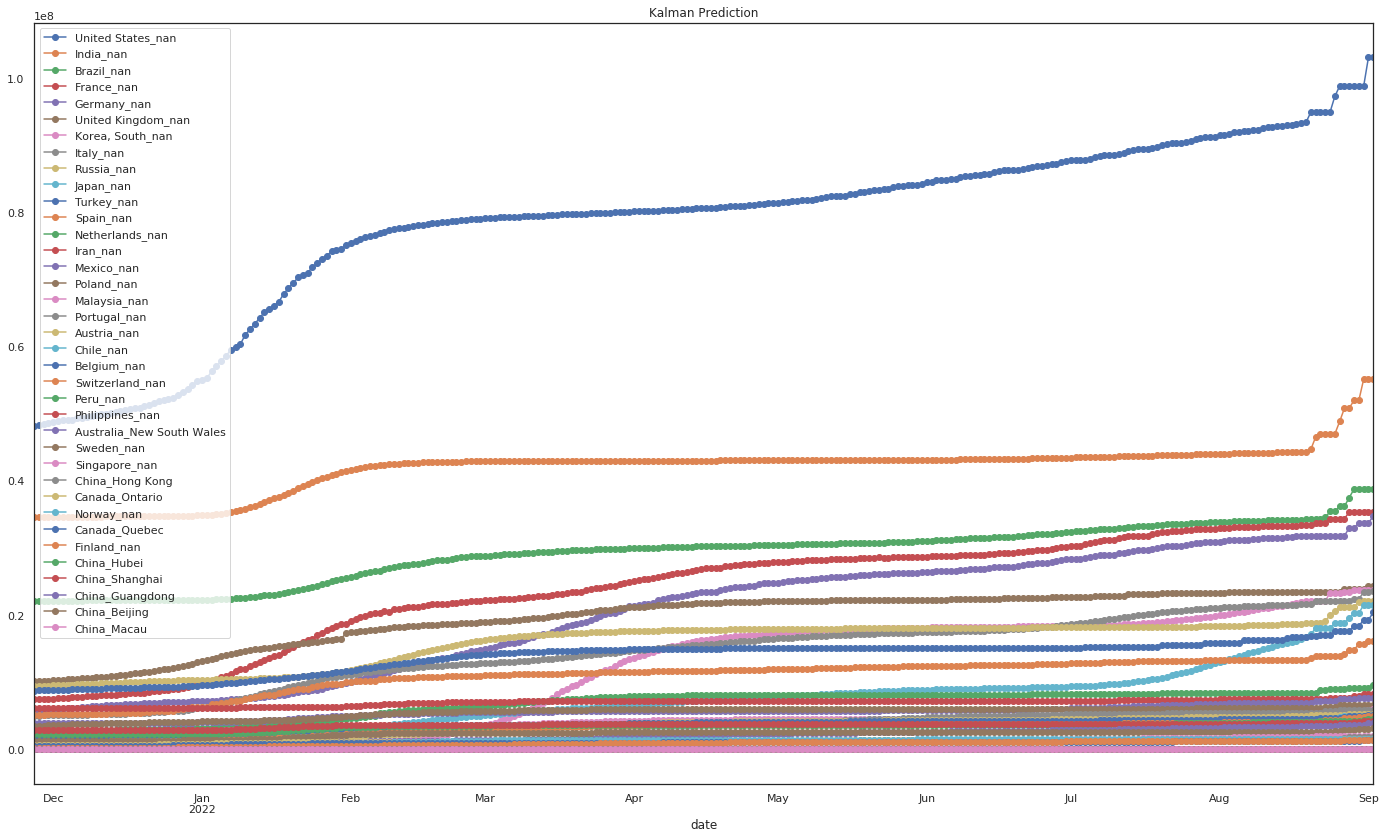

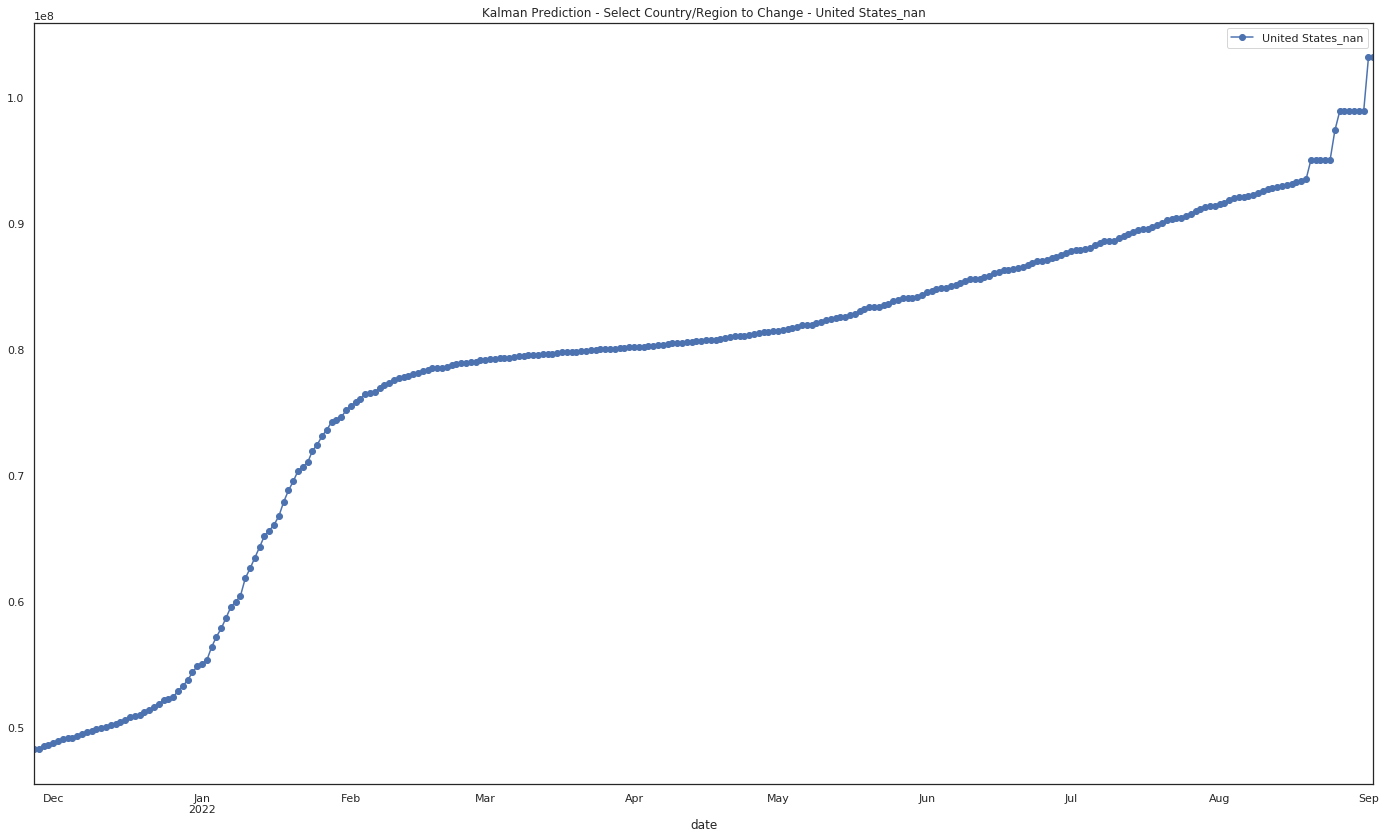

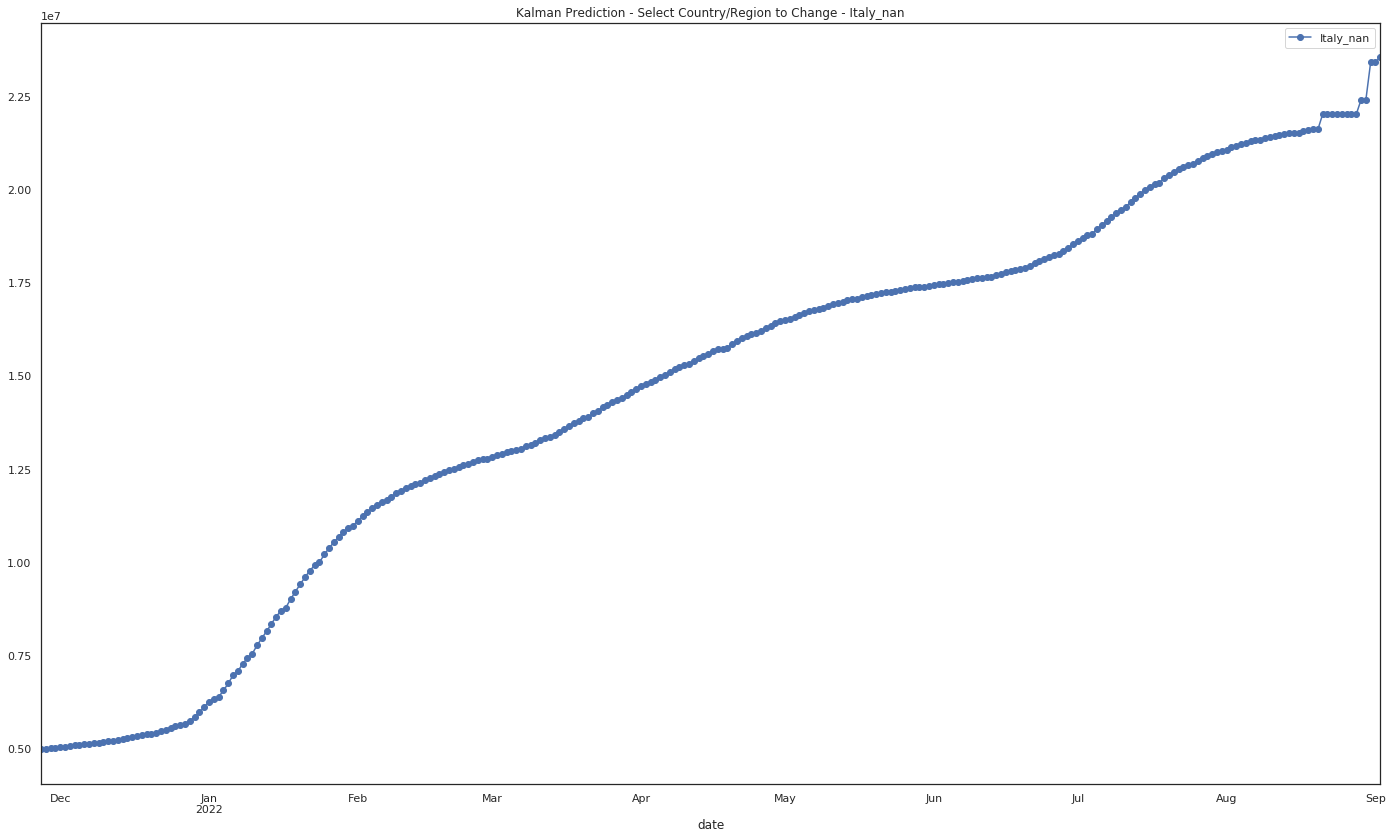

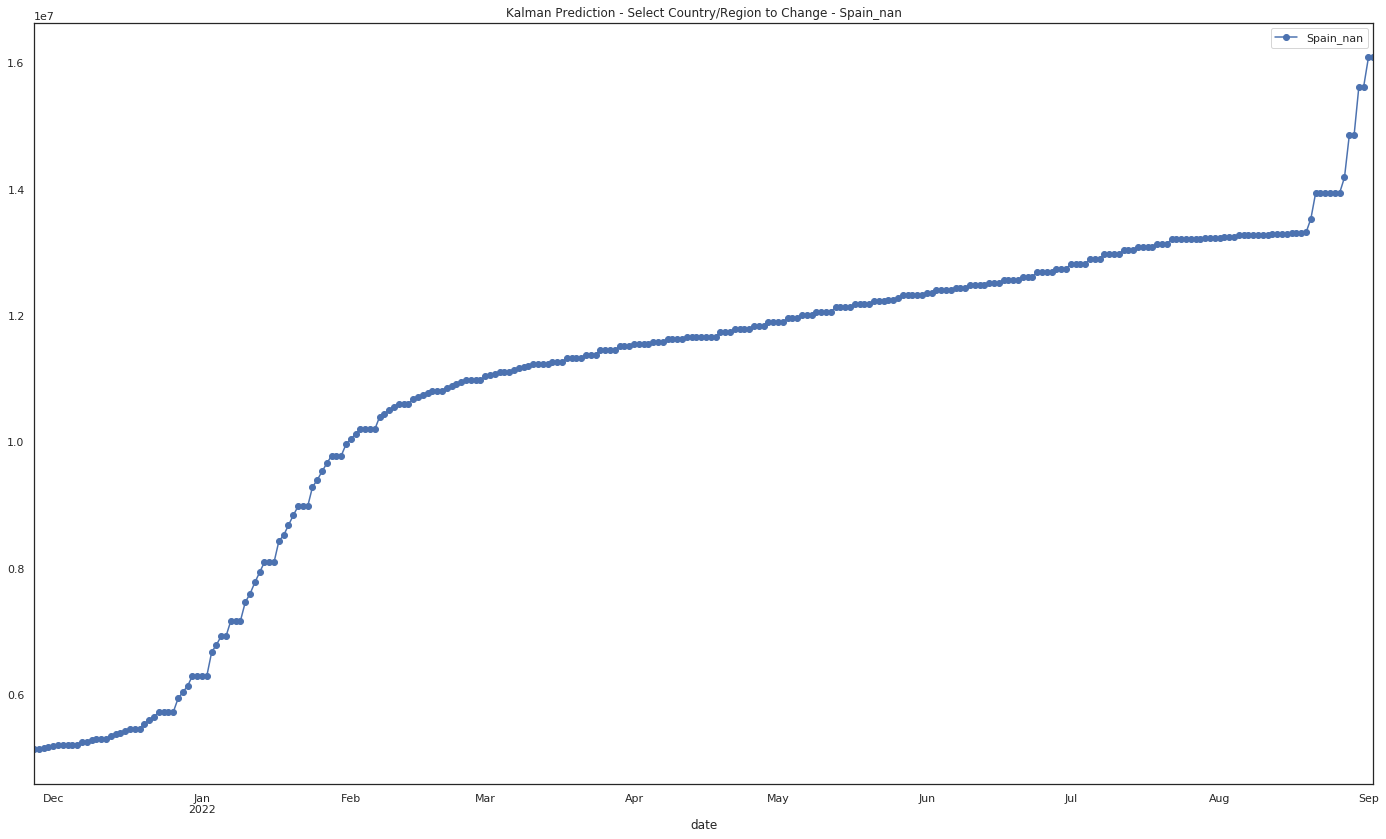

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


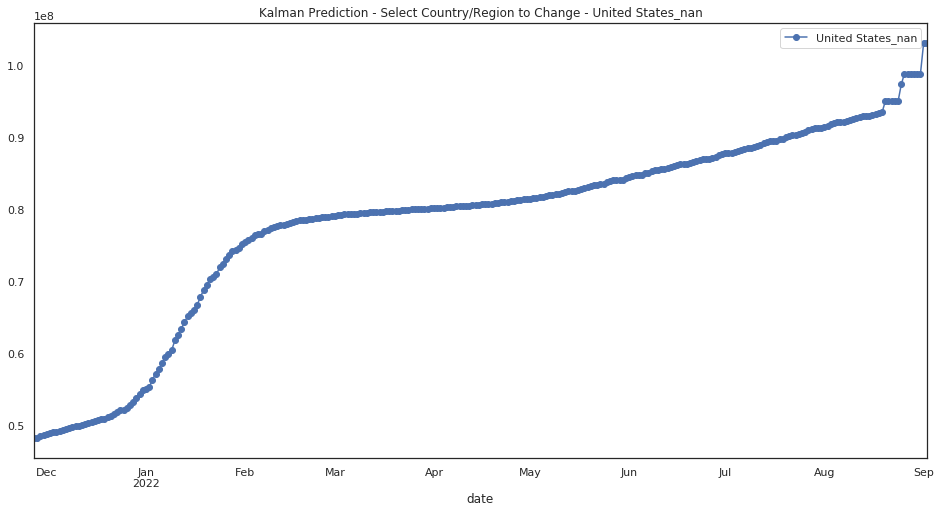

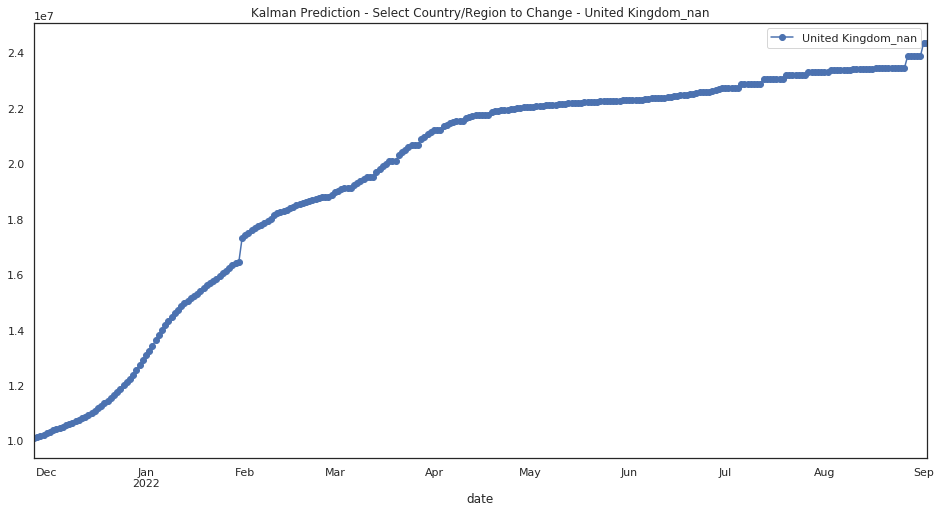

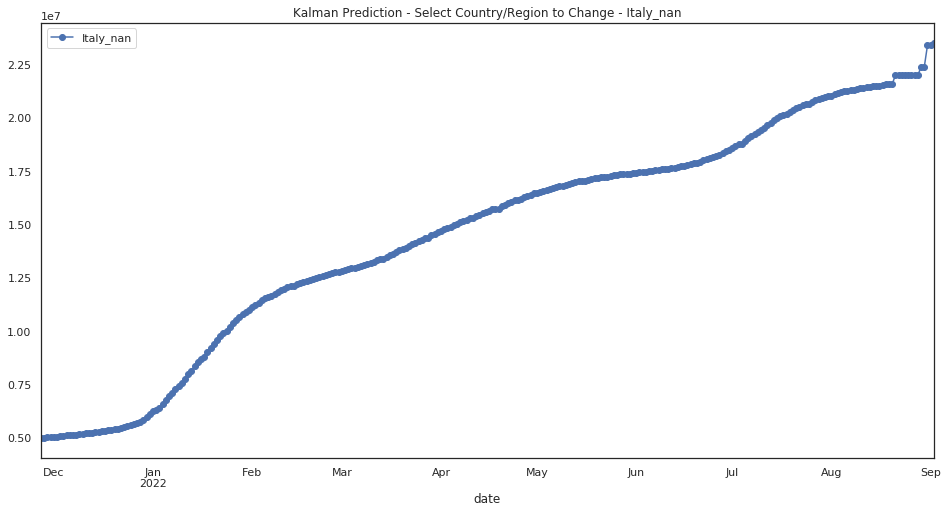

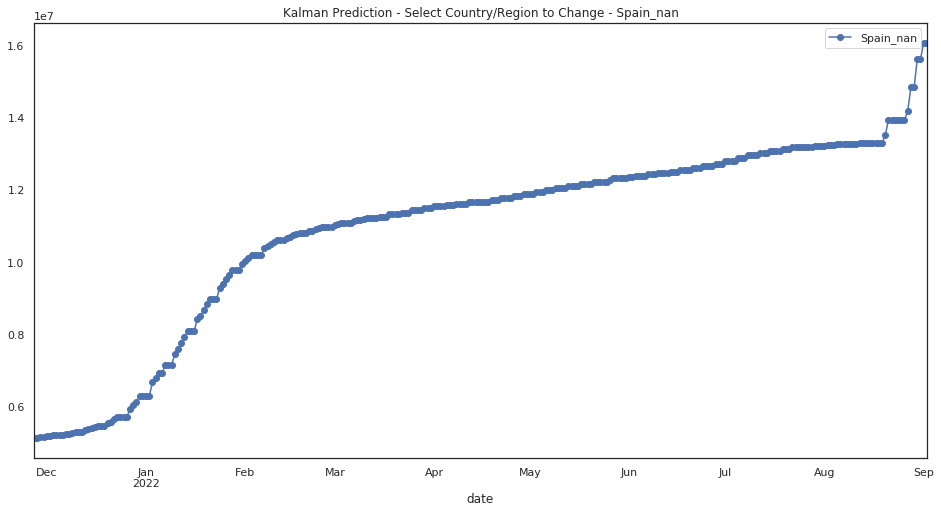

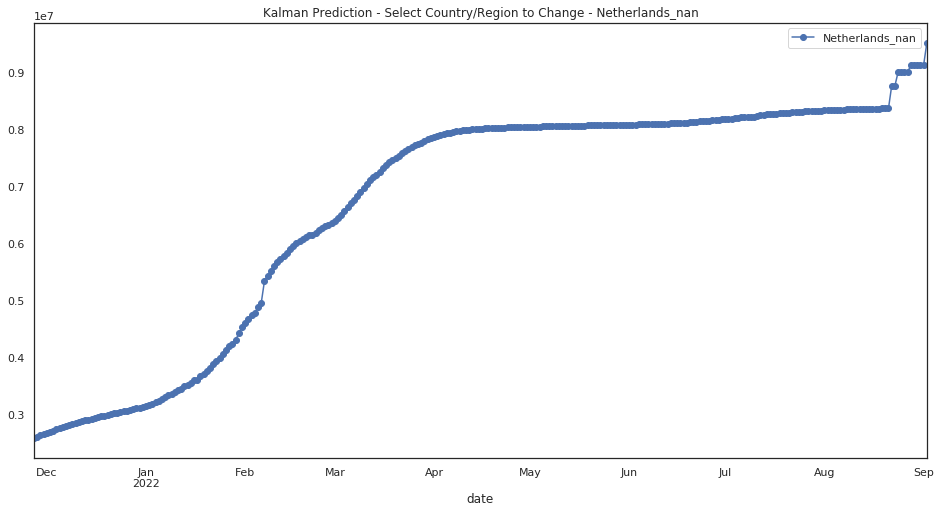

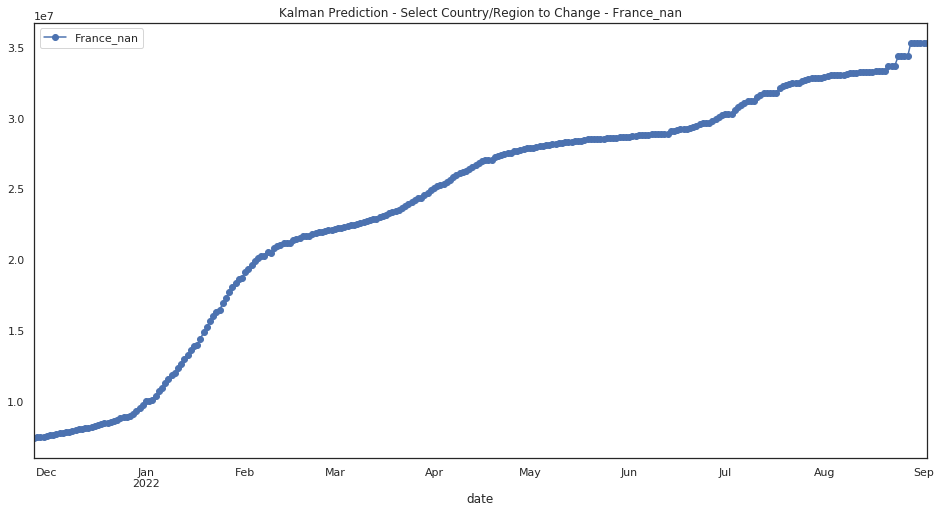

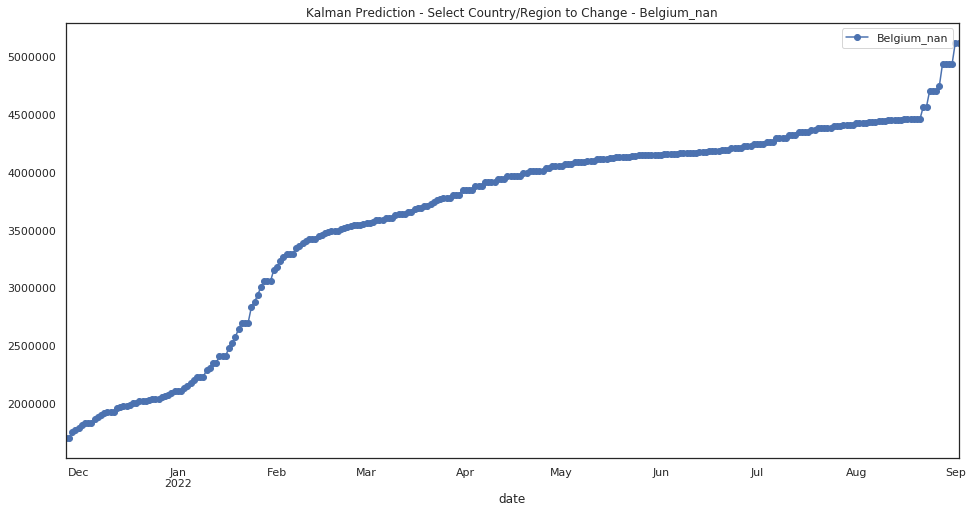

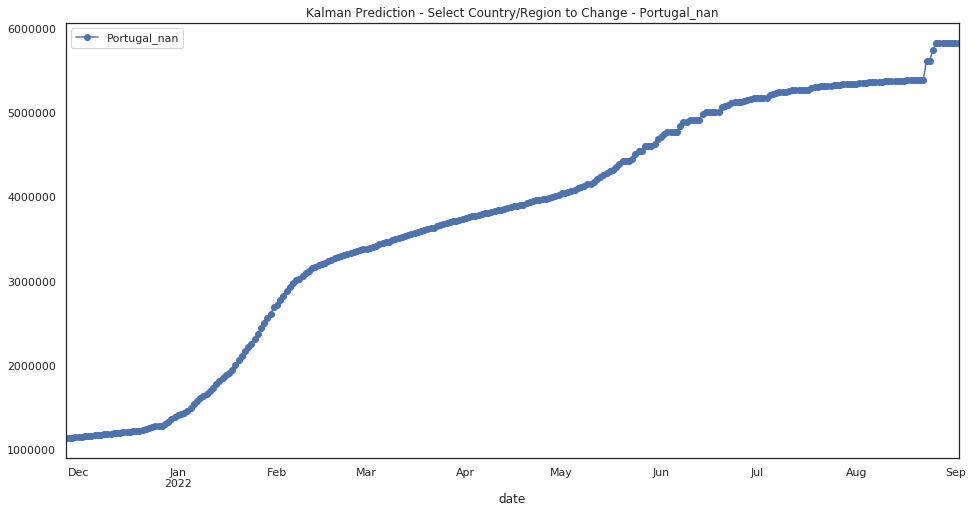

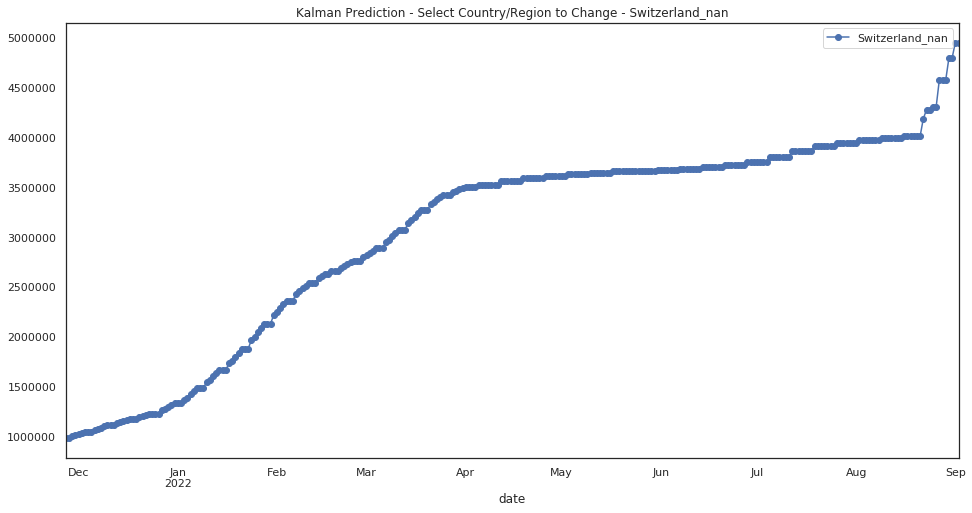

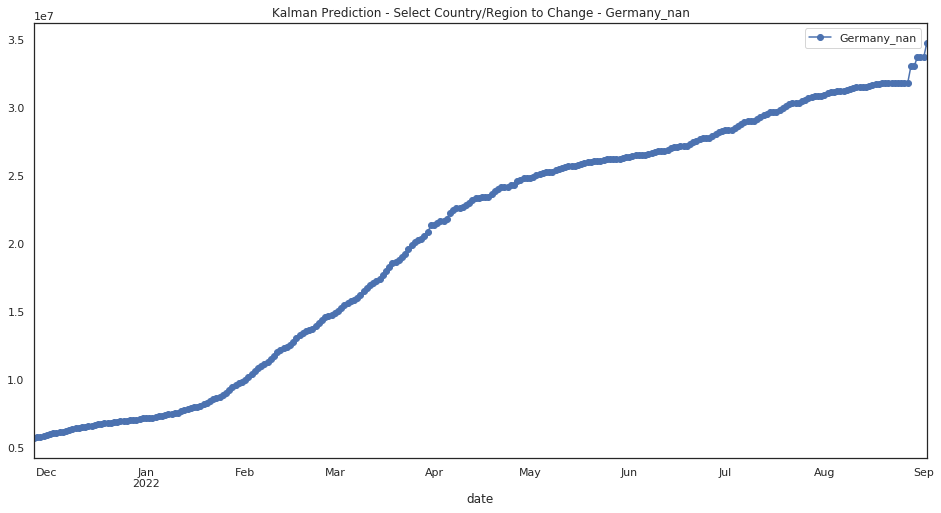

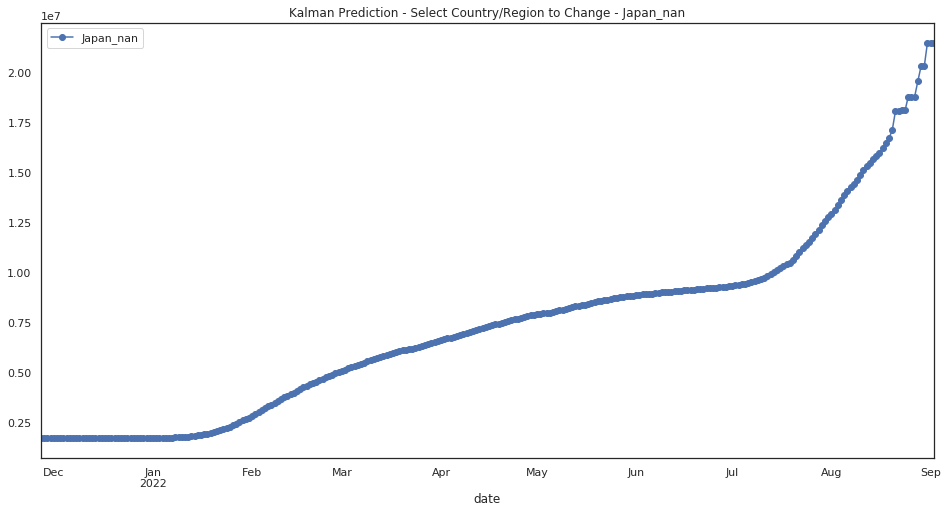

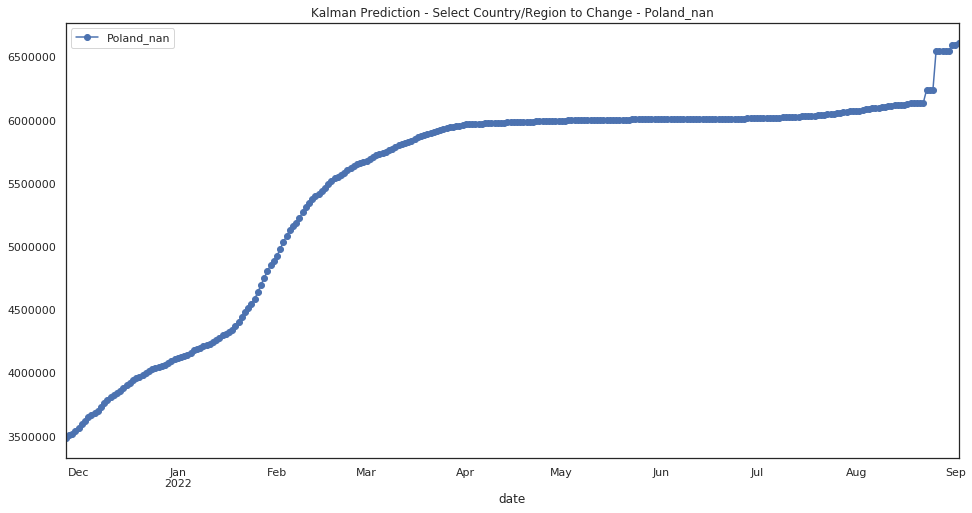

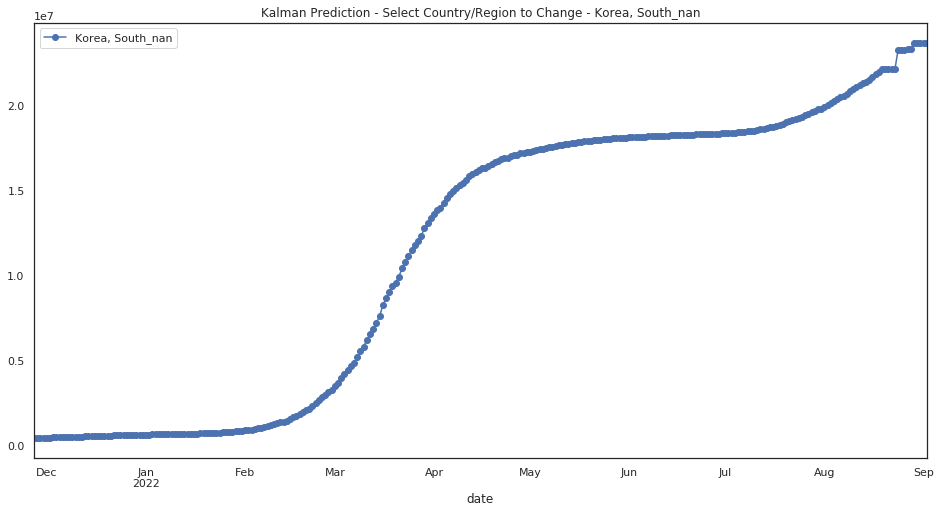

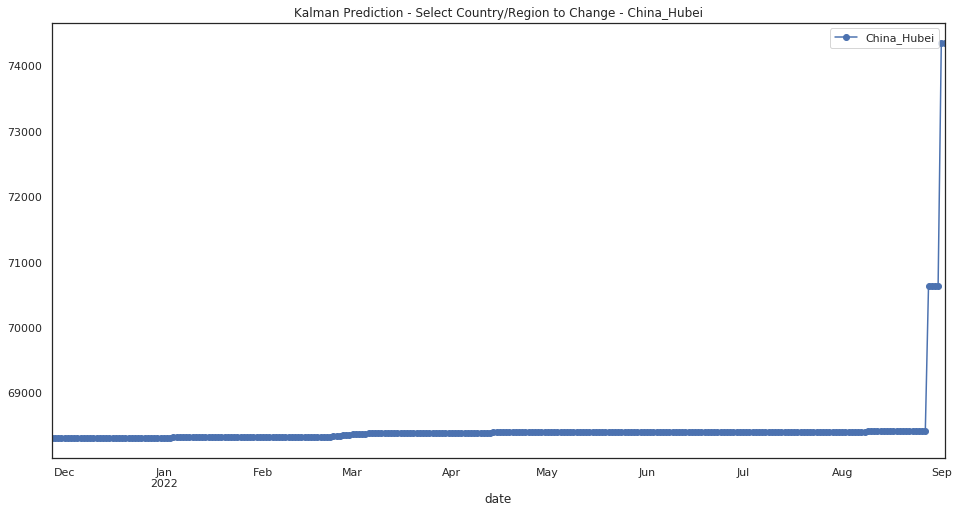

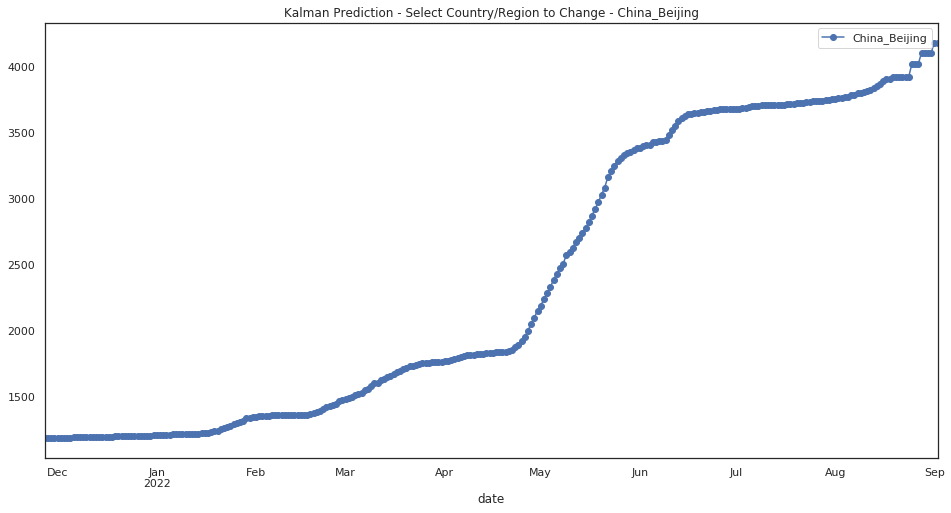

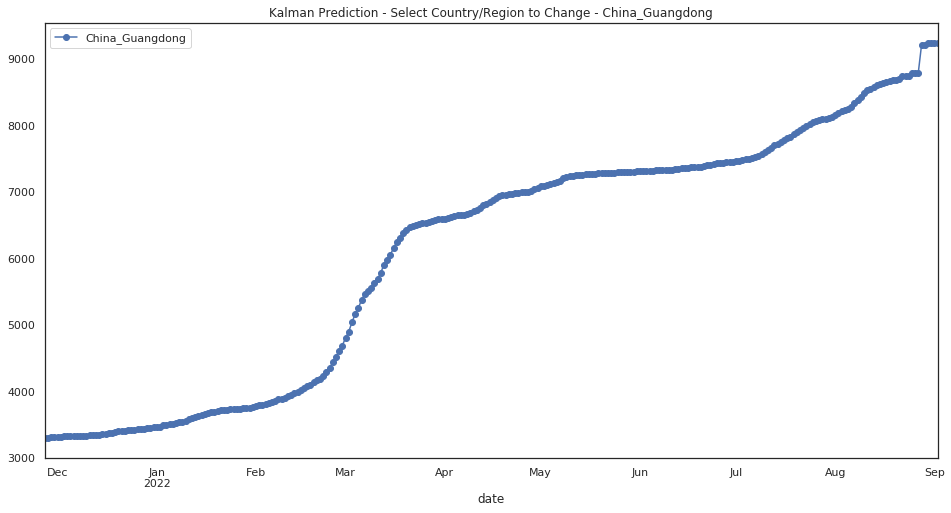

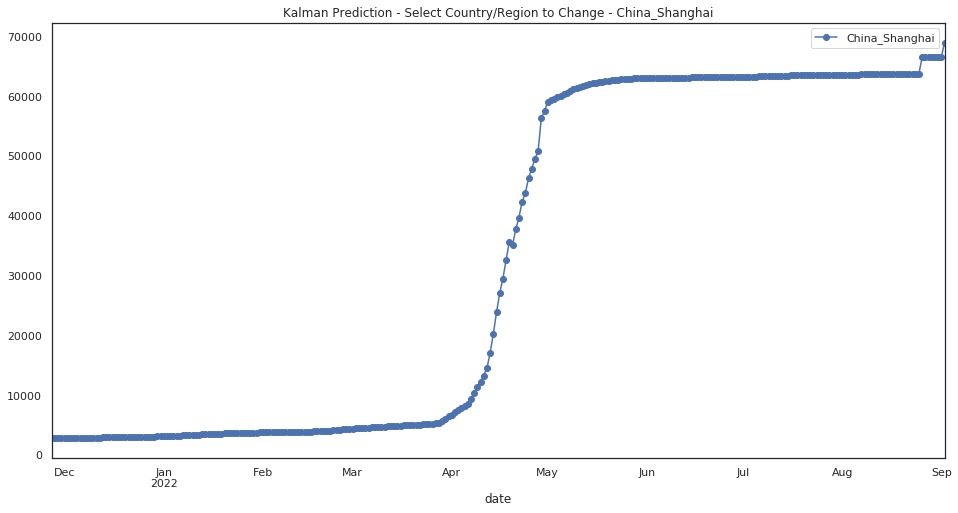

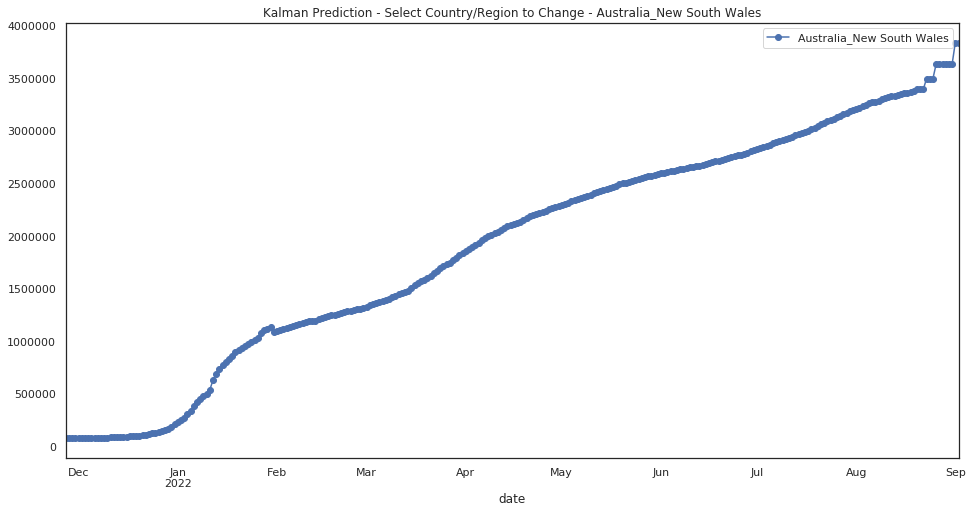

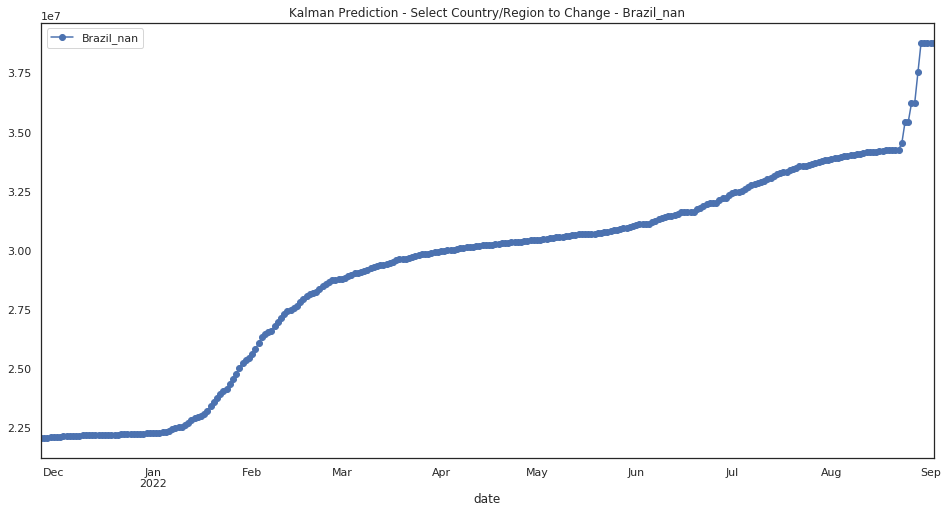

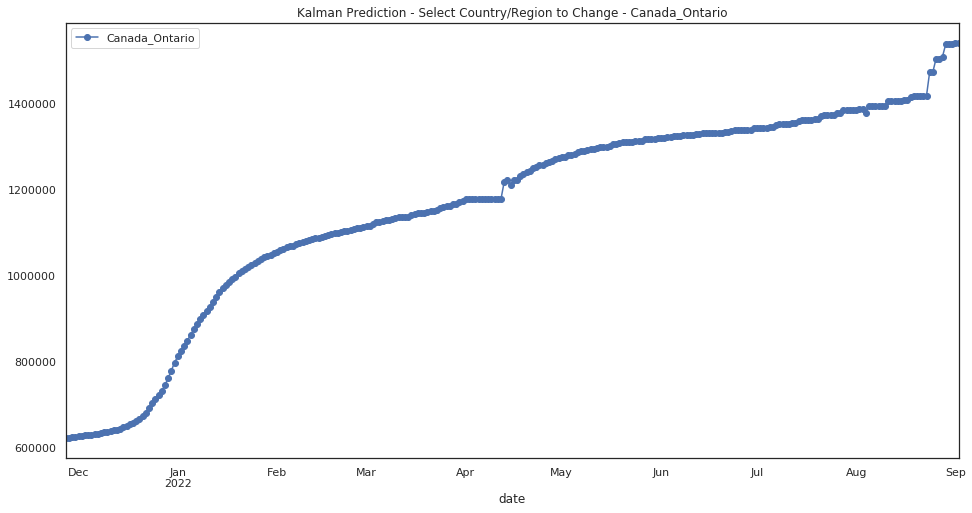

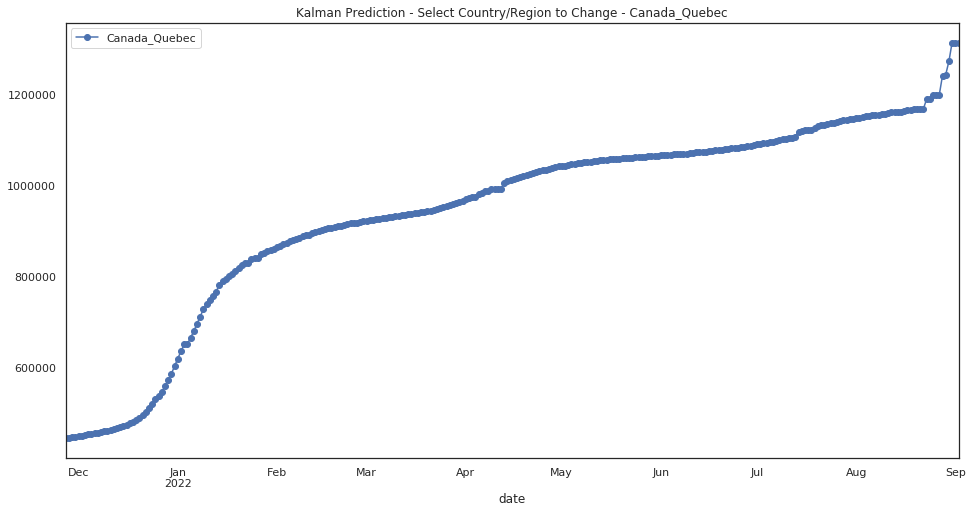

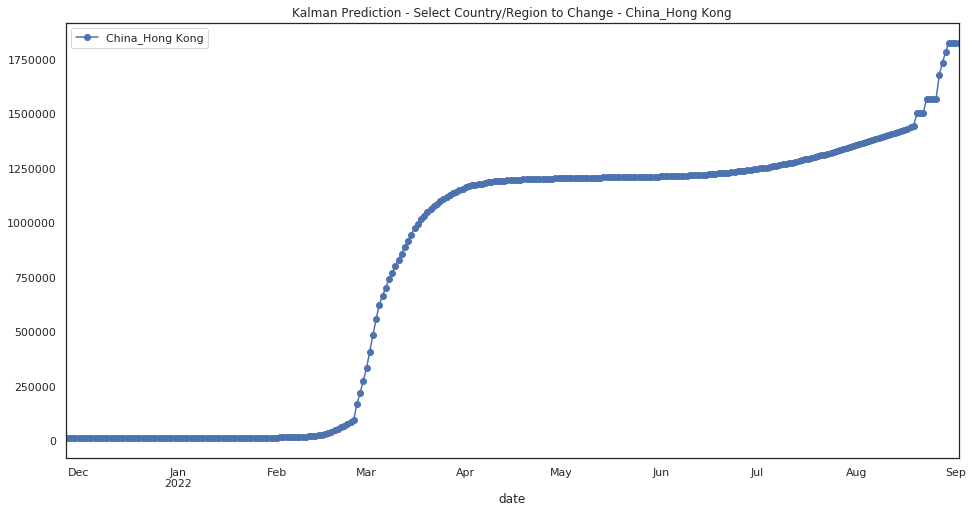

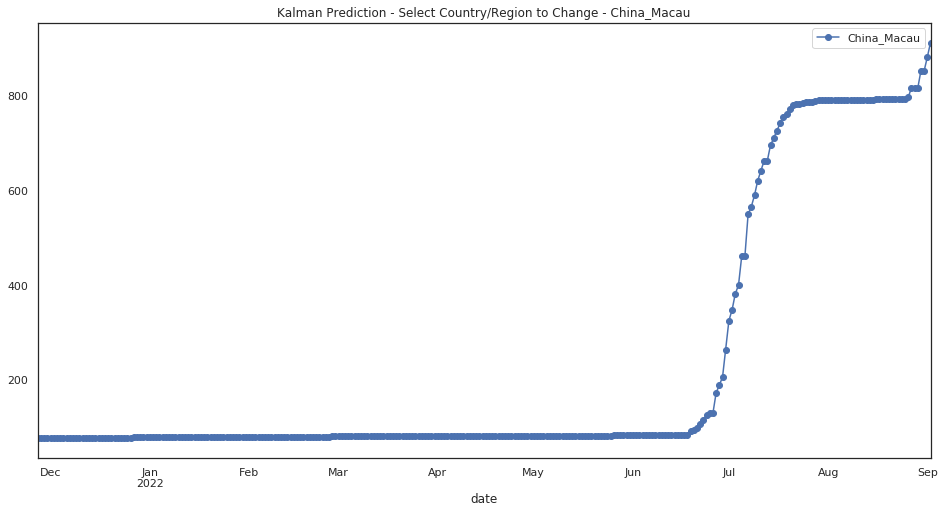

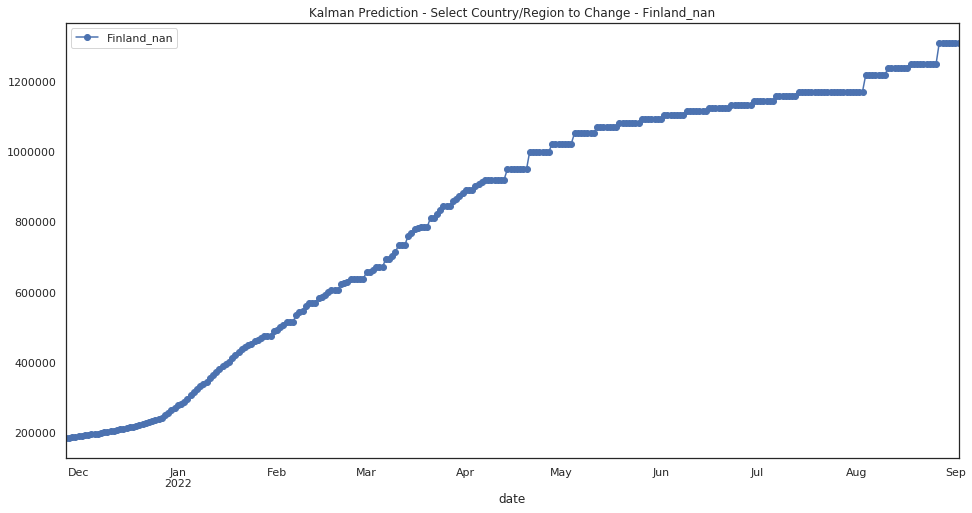

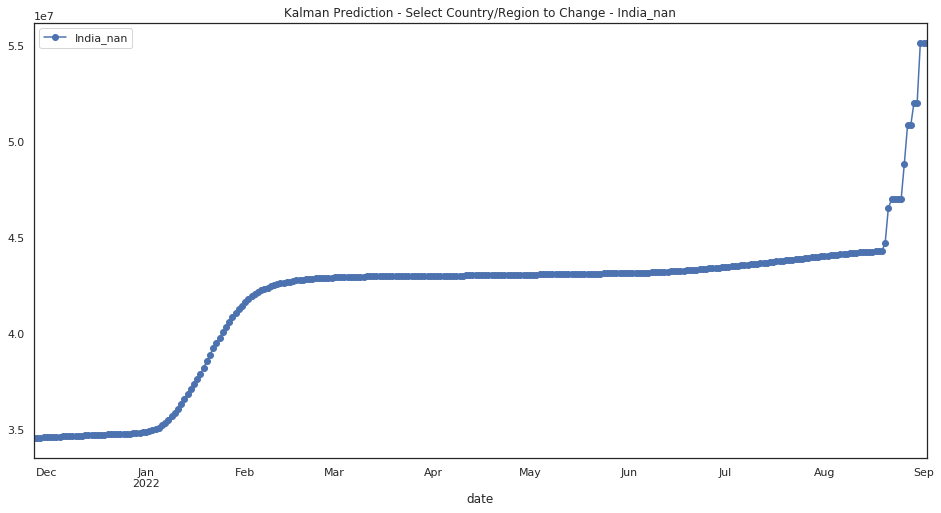

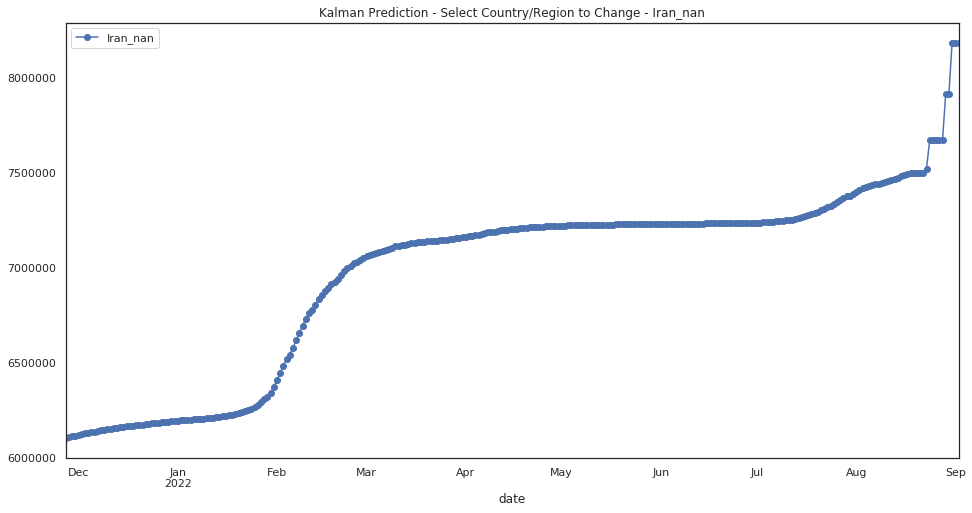

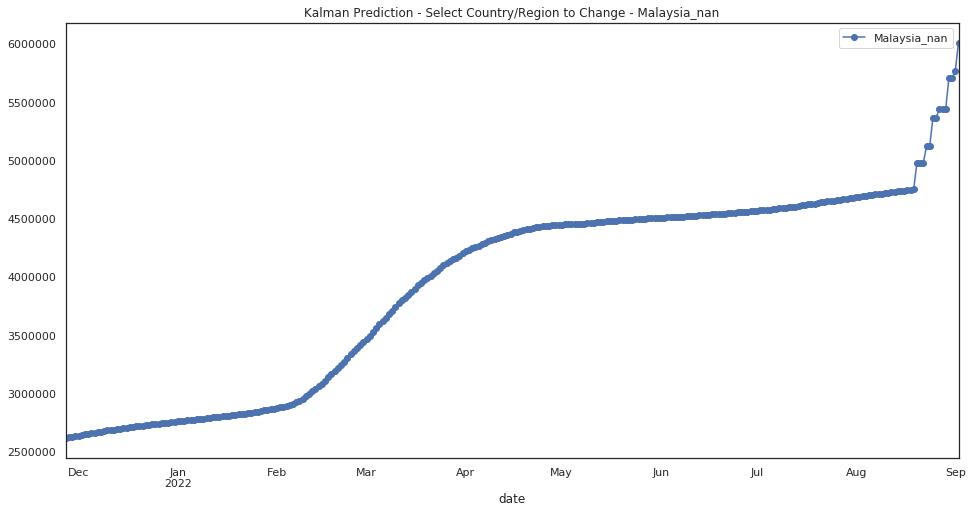

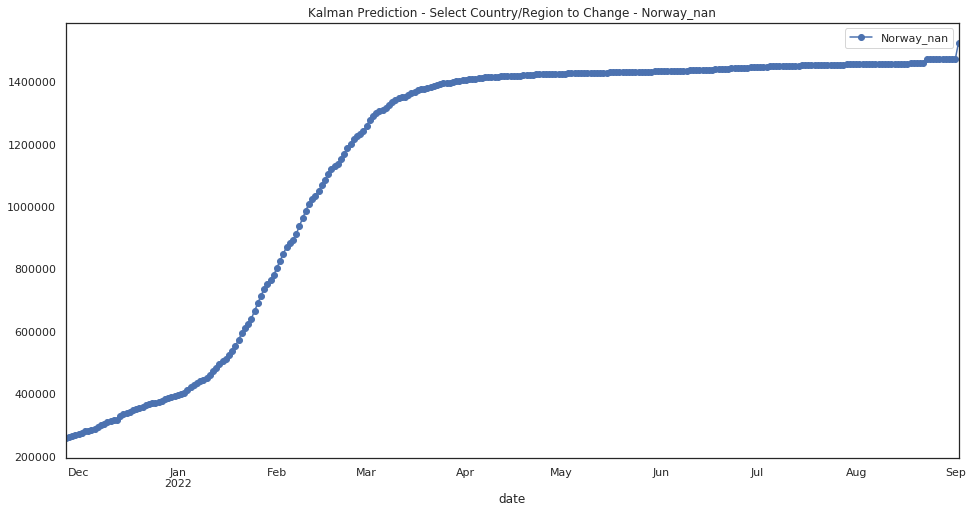

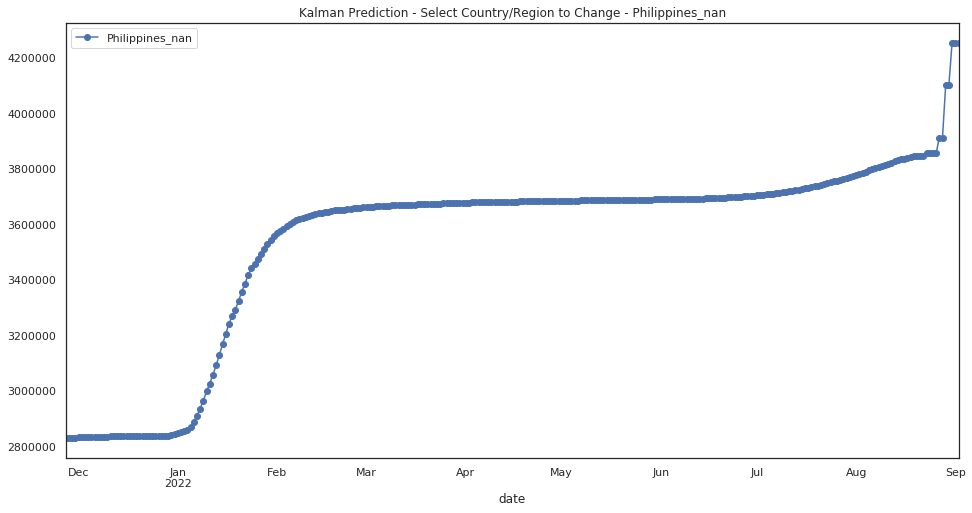

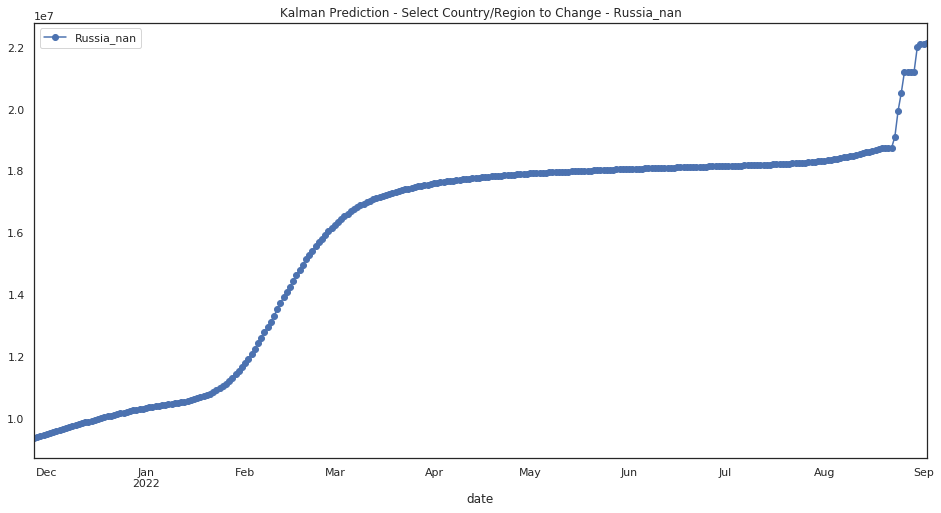

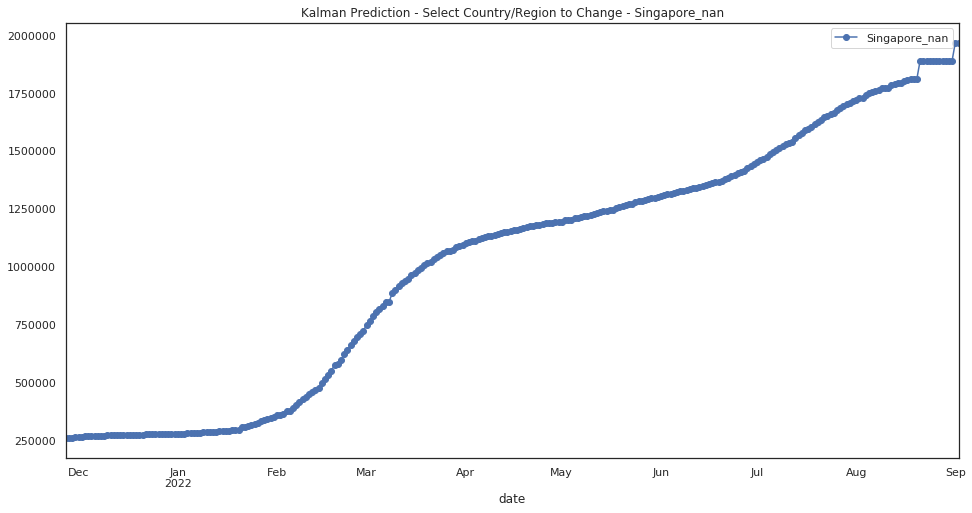

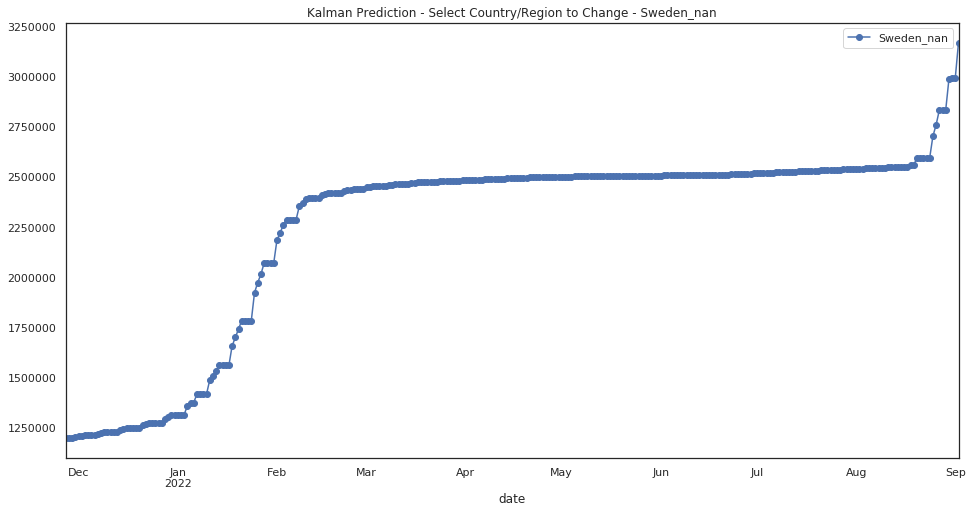

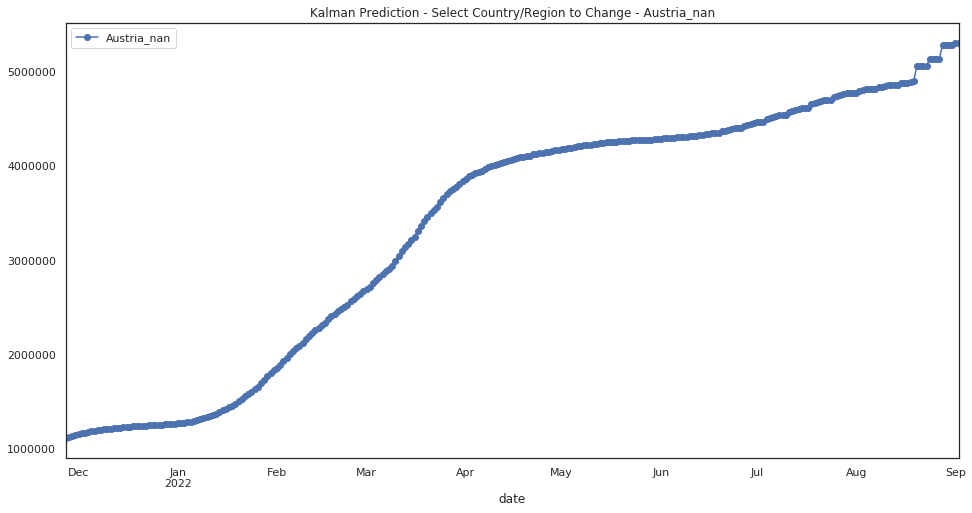

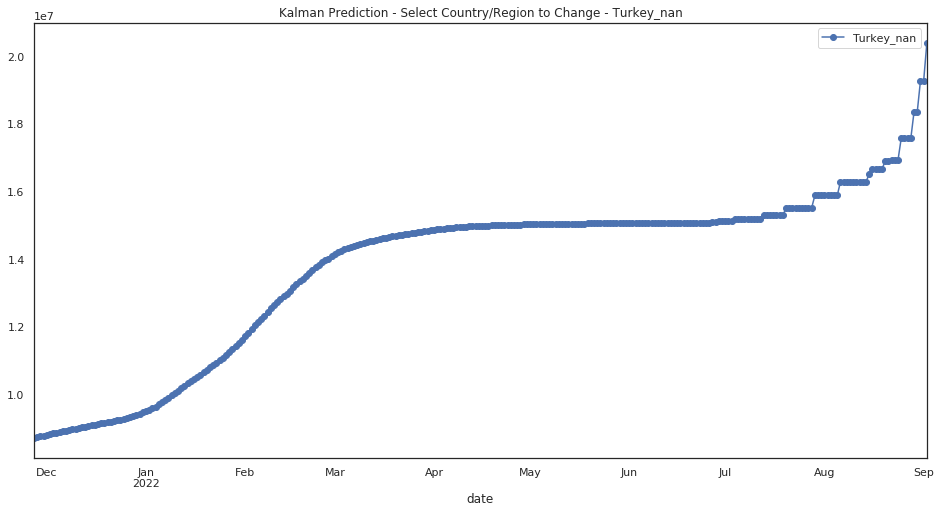

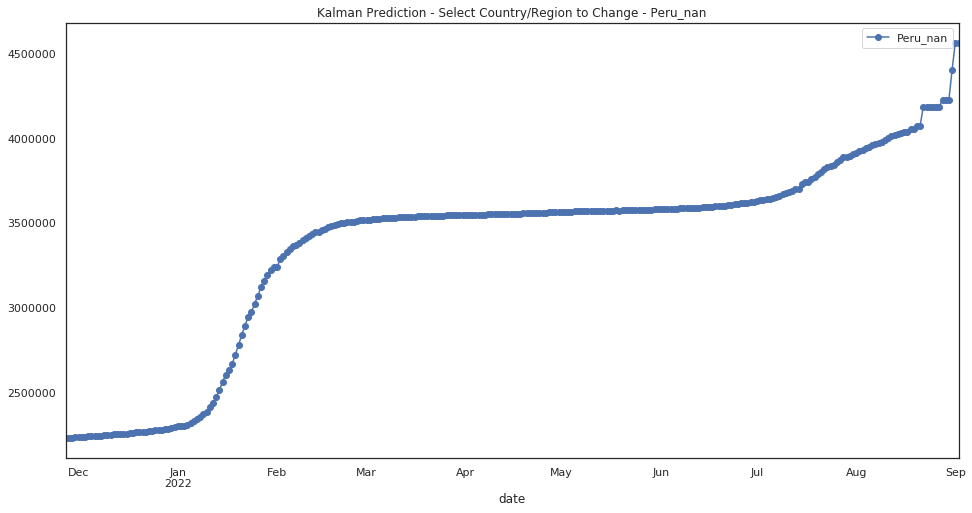

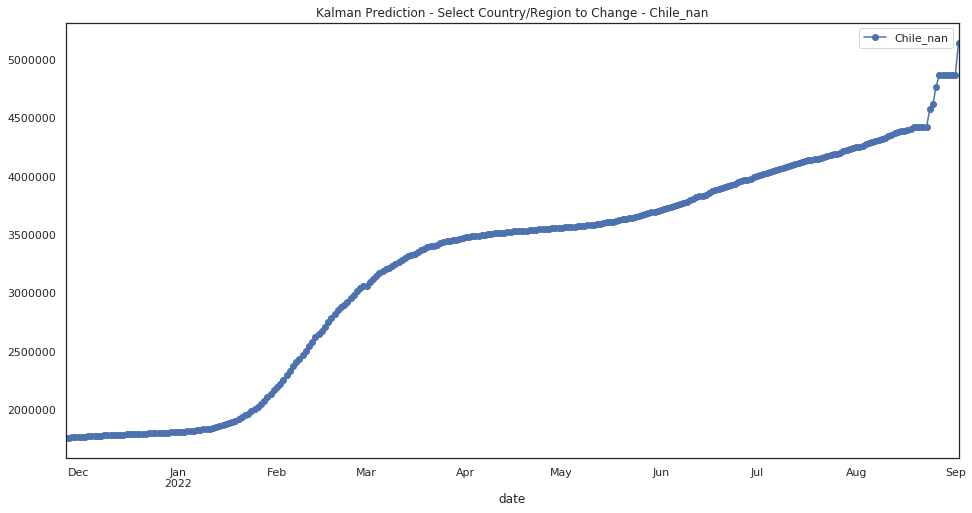

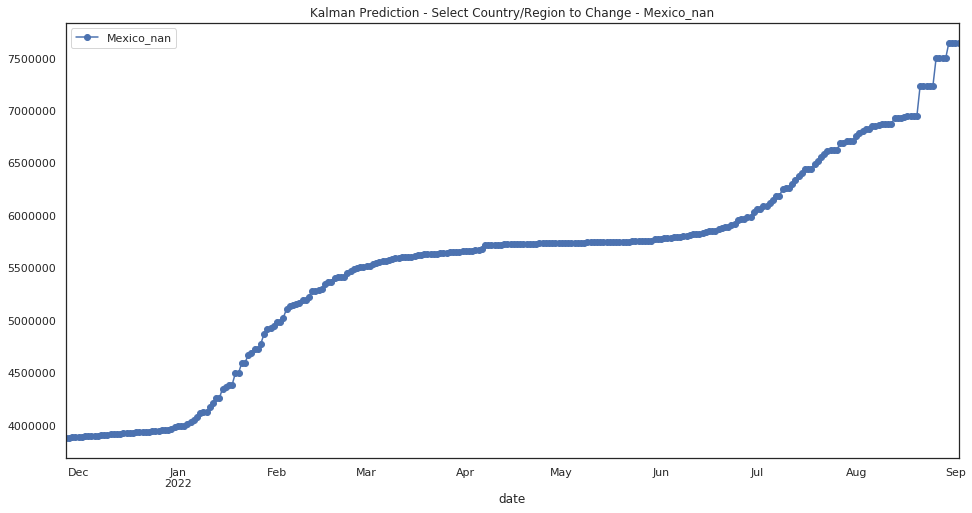

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-09-02 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     103193513.0
India_nan                                           NaN      55173354.0
Brazil_nan                                          NaN      38788435.0
France_nan                                          NaN      35364059.0
Germany_nan                                         NaN      34788012.0
United Kingdom_nan                                  NaN      24375282.0
Korea, South_nan                                    NaN      23710947.0
Italy_nan                                           NaN      23542578.0
Russia_nan                                          NaN      22156619.0
Japan_nan                                           NaN      21484237.0
Turkey_nan                                          NaN      20404324.0
Spain_nan                                           NaN      16088629.0
Vietnam_nan                                         NaN      14295705.0
Argentina_nan                                       NaN      11711205.0
Netherlands_nan                                     NaN       9526527.0
Colombia_nan                                        NaN       8302479.0
Iran_nan                                            NaN       8186611.0
Mexico_nan                                          NaN       7648997.0
Indonesia_nan                                       NaN       7195454.0
Poland_nan                                          NaN       6613805.0
Malaysia_nan                                        NaN       6011392.0
Ukraine_nan                                         NaN       6003493.0
Portugal_nan                                        NaN       5831979.0
Austria_nan                                         NaN       5308923.0
Taiwan*_nan                                         NaN       5295723.0
Greece_nan                                          NaN       5222446.0
Chile_nan                                           NaN       5147707.0
Thailand_nan                                        NaN       5133578.0
Belgium_nan                                         NaN       5123495.0
Israel_nan                                          NaN       5041593.0
...                                                 ...             ...
China_Yunnan                                        NaN          2429.0
United Kingdom_Falkland Islands (Malvinas)          NaN          2277.0
China_Hebei                                         NaN          2269.0
China_Liaoning                                      NaN          1998.0
China_Jiangxi                                       NaN          1728.0
China_Hunan                                         NaN          1671.0
China_Anhui                                         NaN          1619.0
China_Gansu                                         NaN          1416.0
United Kingdom_Montserrat                           NaN          1205.0
China_Xinjiang                                      NaN          1158.0
Summer Olympics 2020_nan                            NaN          1012.0
China_Macau                                         NaN           913.0
China_Chongqing                                     NaN           873.0
France_Wallis and Futuna                            NaN           866.0
Diamond Princess_nan                                NaN           839.0
Winter Olympics 2022_nan                            NaN           598.0
China_Shanxi                                        NaN           489.0
China_Tibet                                         NaN           419.0
China_Guizhou                                       NaN           227.0
China_Qinghai                                       NaN           203.0
China_Ningxia                                       NaN           131.0
Holy See_nan                                        NaN            34.0
Canada_Repatriated Travellers                       NaN            17.0
Canada_Grand Princess                               NaN            15.0
Antarctica_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-11-27         276551.0     312440.0     321717.0     156362.0   
2021-11-28         276575.0     312798.0     321864.0     156362.0   
2021-11-29         157218.0     199555.0     210152.0      16712.0   
2021-11-30         157260.0     199750.0     210344.0      16712.0   
2021-12-01         159038.0     201423.0     212376.0      17115.0   
2021-12-02         159061.0     201846.0     212574.0      17426.0   
2021-12-03         159098.0     202244.0     212766.0      17658.0   
2021-12-04         159119.0     202618.0     212952.0      18010.0   
2021-12-05         159704.0     203402.0     213626.0      19147.0   
2021-12-06         159745.0     203601.0     213816.0      19557.0   
2021-12-07         159753.0     203972.0     214011.0      18631.0   
2021-12-08         159795.0     204293.0     214200.0      18815.0   
2021-12-09         159831.0     204531.0     214380.0      20373.0   
2021-12-10         159849.0     204890.0     214586.0      19272.0   
2021-12-11         159867.0     205195.0     214801.0      19440.0   
2021-12-12         159890.0     205470.0     214998.0      20451.0   
2021-12-13         159901.0     205634.0     215206.0      20233.0   
2021-12-14         159917.0     205983.0     215432.0      20769.0   
2021-12-15         159924.0     206299.0     215672.0      20136.0   
2021-12-16         159979.0     206610.0     215886.0      21468.0   
2021-12-17         159980.0     206907.0     216172.0      20549.0   
2021-12-18         160006.0     207229.0     216452.0      21364.0   
2021-12-19         160043.0     207468.0     216715.0      21364.0   
2021-12-20         160046.0     207611.0     216959.0      21621.0   
2021-12-21         160074.0     207955.0     217257.0      21062.0   
2021-12-22         160095.0     208284.0     217539.0      22145.0   
2021-12-23         160127.0     208610.0     217830.0      21372.0   
2021-12-24         160139.0     208905.0     218189.0      21571.0   
2021-12-25         160155.0     209222.0     218475.0      21730.0   
2021-12-26         160204.0     209408.0     218743.0      22412.0   
...                     ...          ...          ...          ...   
2022-08-05         189147.0     317417.0     270227.0      45793.0   
2022-08-06         189242.0     318262.0     270337.0      45793.0   
2022-08-07         189572.0     318856.0     270445.0      45793.0   
2022-08-08         189782.0     319032.0     270547.0      45793.0   
2022-08-09         190065.0     319811.0     270664.0      45793.0   
2022-08-10         190303.0     320795.0     270774.0      45793.0   
2022-08-11         190603.0     321444.0     270903.0      45899.0   
2022-08-12         190808.0     322111.0     271052.0      45899.0   
2022-08-13         190957.0     322708.0     271195.0      45899.0   
2022-08-14         191173.0     323171.0     271327.0      45899.0   
2022-08-15         191449.0     323496.0     271454.0      45899.0   
2022-08-16         191596.0     324113.0     271566.0      45899.0   
2022-08-17         191846.0     324684.0     271660.0      45899.0   
2022-08-18         192124.0     325187.0     271742.0      45975.0   
2022-08-19         192367.0     326499.0     271836.0      45975.0   
2022-08-20         192410.0     326826.0     271854.0      45975.0   
2022-08-21         192444.0     326588.0     282147.0      47015.0   
2022-08-22         192449.0     334524.0     284485.0      48723.0   
2022-08-23         192460.0     337127.0     283323.0      49868.0   
2022-08-24         192468.0     335394.0     283330.0      49868.0   
2022-08-25         192481.0     347439.0     287469.0      50814.0   
2022-08-26         198515.0     351526.0     288552.0      53011.0   
2022-08-27         198370.0     348734.0     287955.0      53140.0   
2022-08-28         199316.0     348734.0     287955.0      55236.0   
2022-08-29

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Germany_nan',
 'United Kingdom_nan',
 'Korea, South_nan',
 'Italy_nan',
 'Russia_nan',
 'Japan_nan',
 'Turkey_nan',
 'Spain_nan',
 'Vietnam_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Colombia_nan',
 'Iran_nan',
 'Mexico_nan',
 'Indonesia_nan',
 'Poland_nan',
 'Malaysia_nan',
 'Ukraine_nan',
 'Portugal_nan',
 'Austria_nan',
 'Taiwan*_nan',
 'Greece_nan',
 'Chile_nan',
 'Thailand_nan',
 'Belgium_nan',
 'Israel_nan',
 'Switzerland_nan',
 'Peru_nan',
 'Czechia_nan',
 'South Africa_nan',
 'Philippines_nan',
 'Australia_New South Wales',
 'Romania_nan',
 'Denmark_nan',
 'Sweden_nan',
 'Iraq_nan',
 'Slovakia_nan',
 'Hungary_nan',
 'Australia_Victoria',
 'Serbia_nan',
 'Bangladesh_nan',
 'New Zealand_nan',
 'Jordan_nan',
 'Australia_Queensland',
 'Singapore_nan',
 'Georgia_nan',
 'Ireland_nan',
 'China_Hong Kong',
 'Morocco_nan',
 'Kazakhstan_nan',
 'Pakistan_nan',
 'Canada_Ontario',
 'Lebanon_nan',
 'Norway_nan',
 'Bulgari

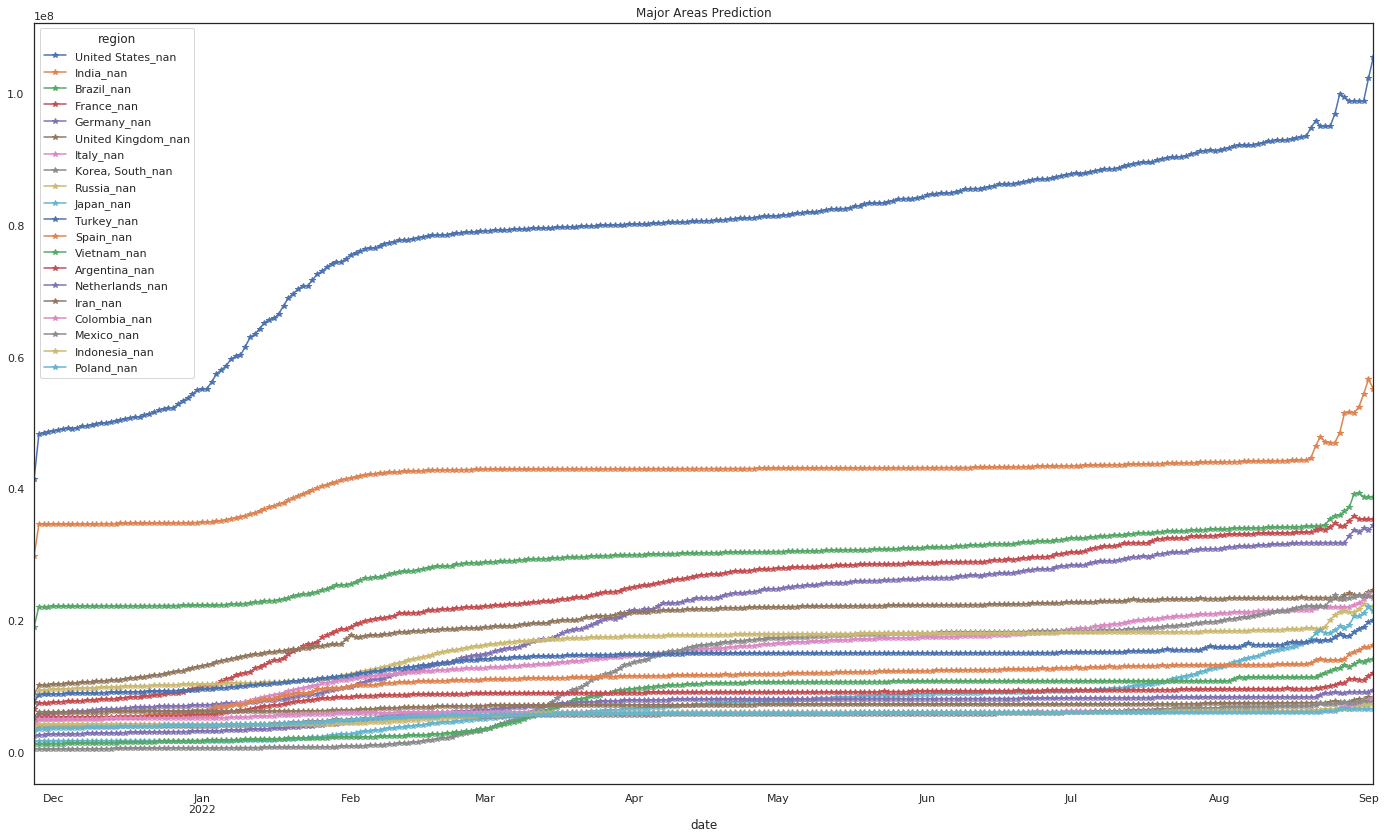

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

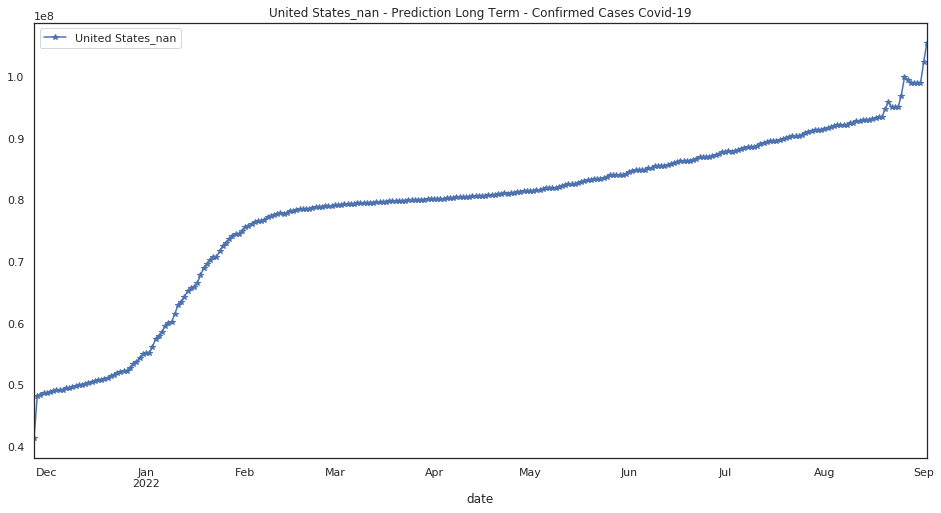

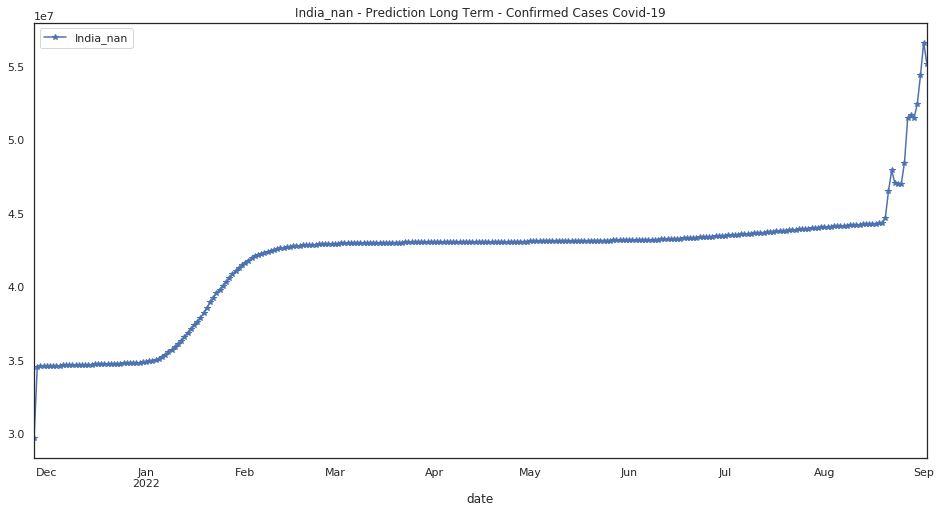

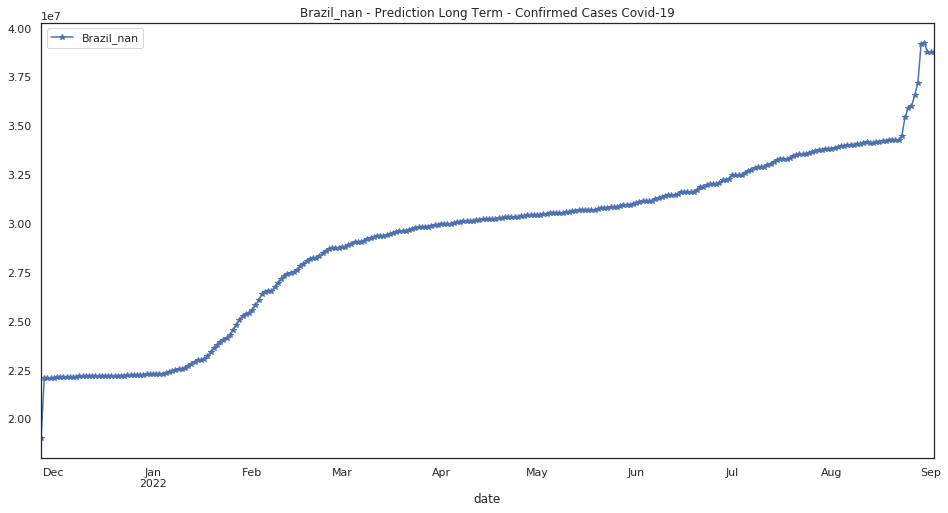

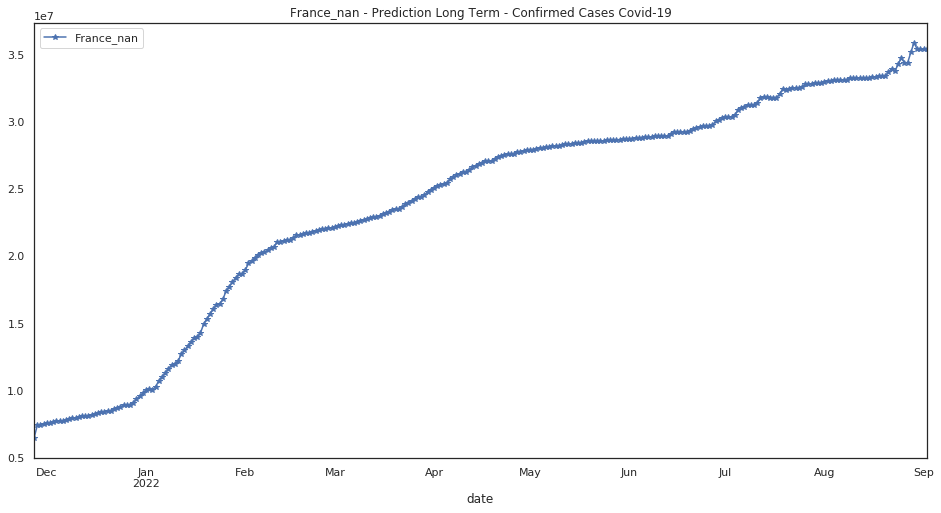

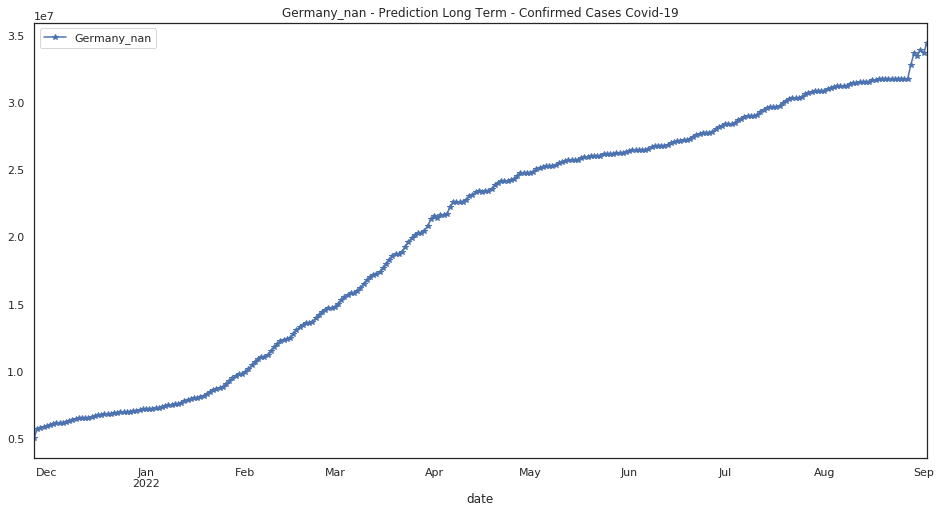

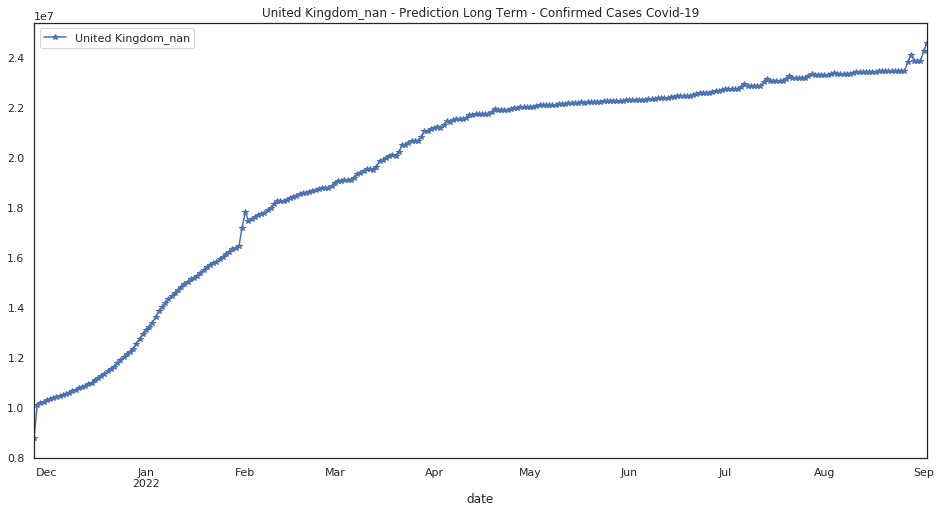

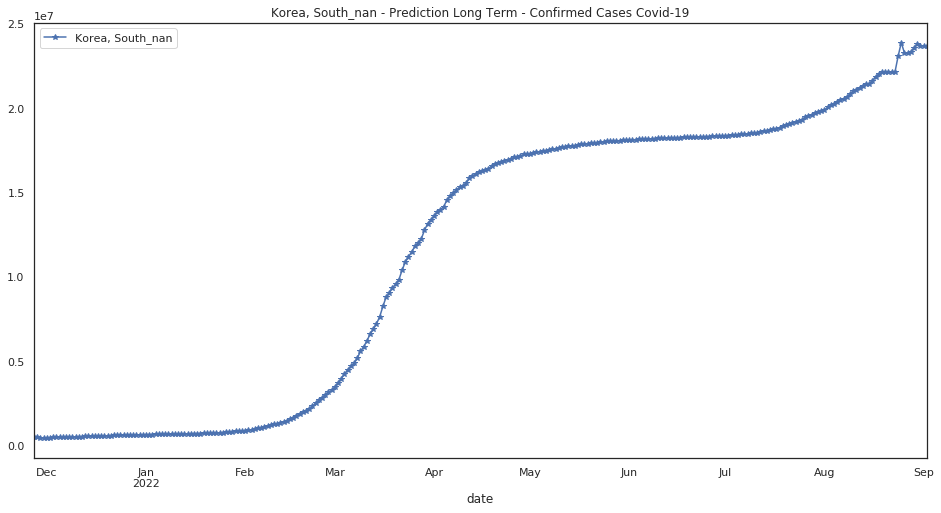

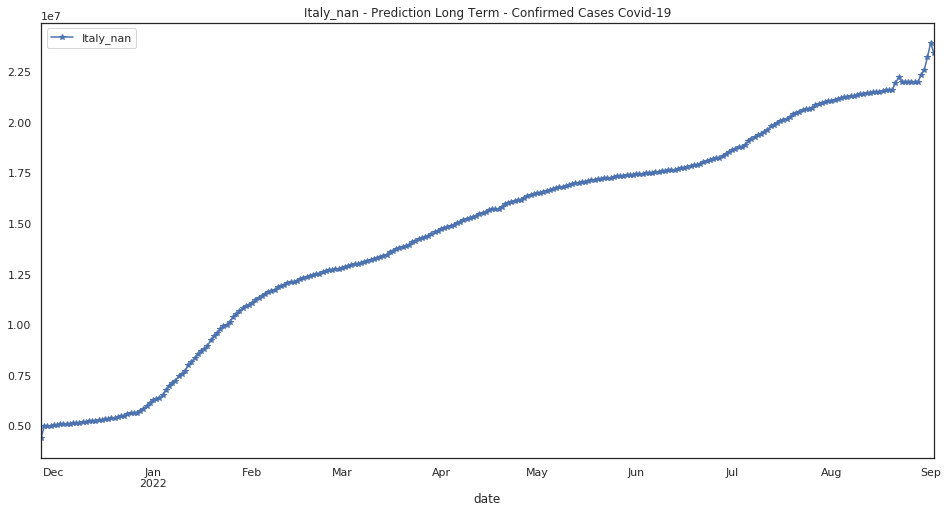

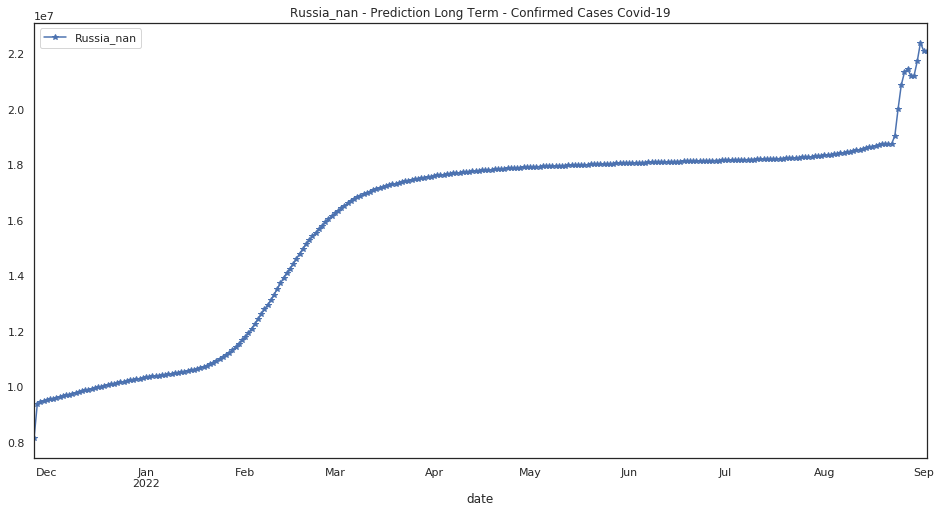

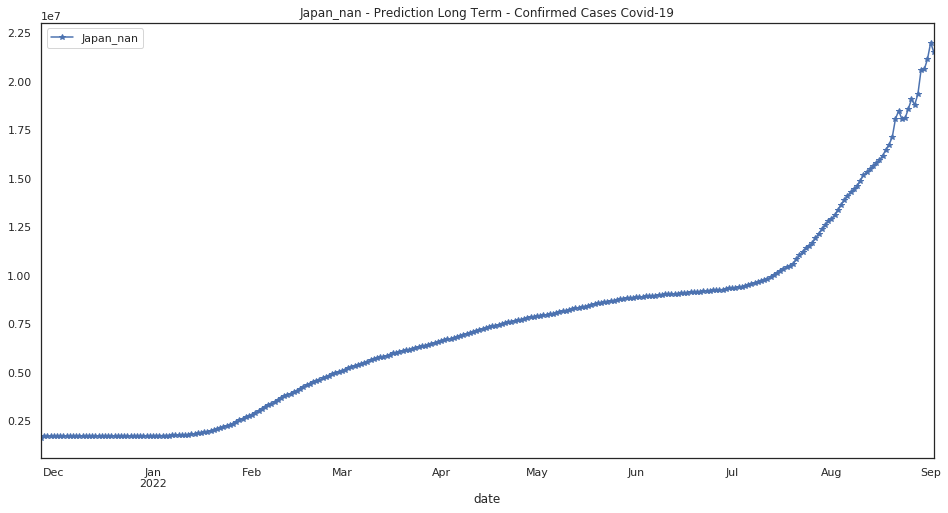

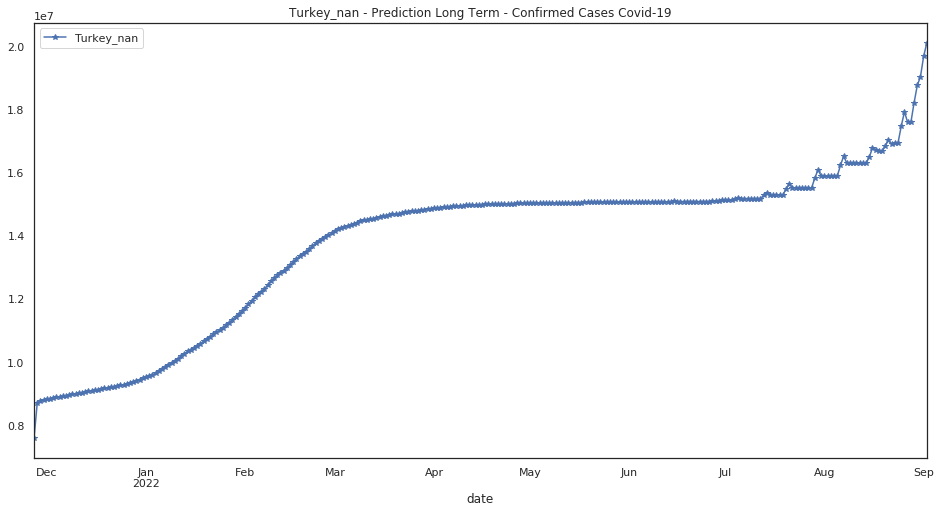

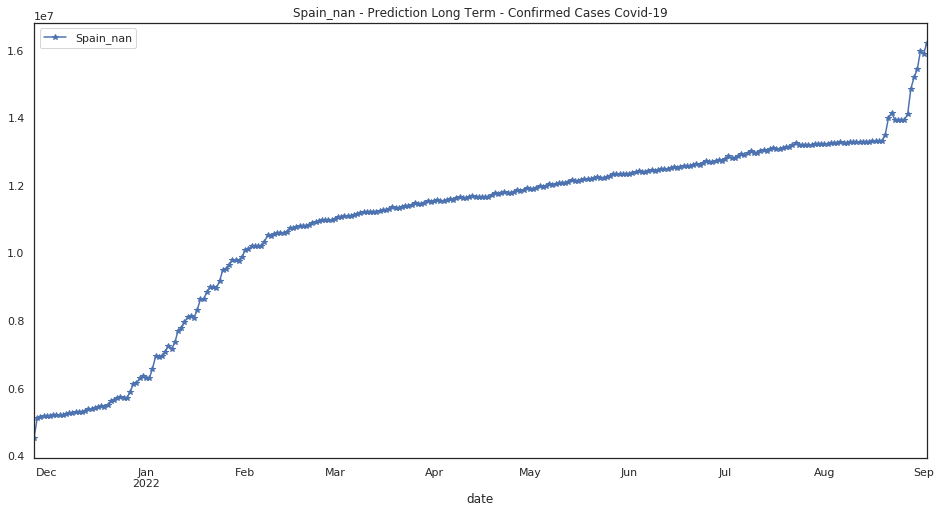

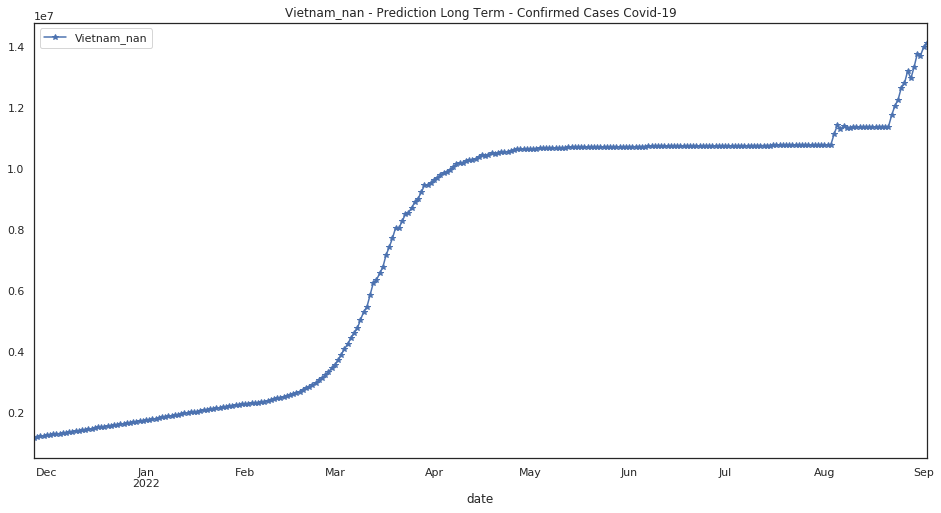

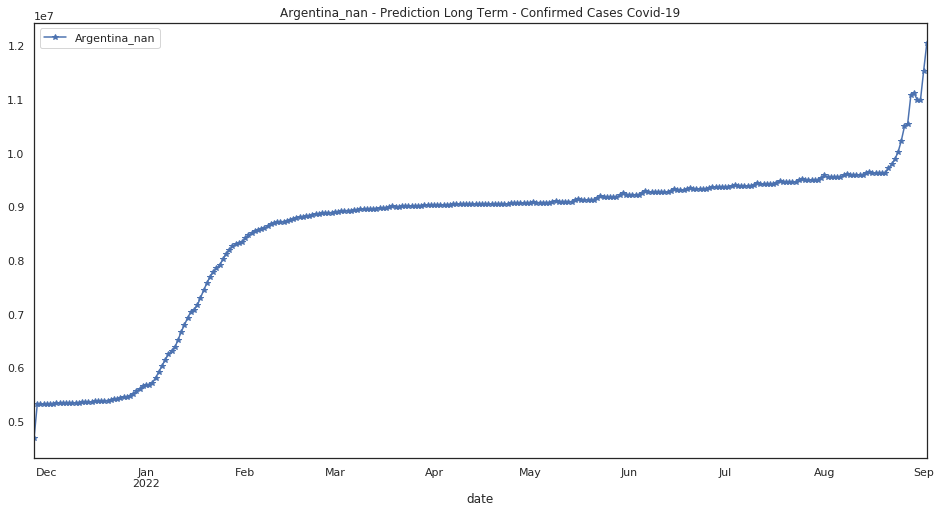

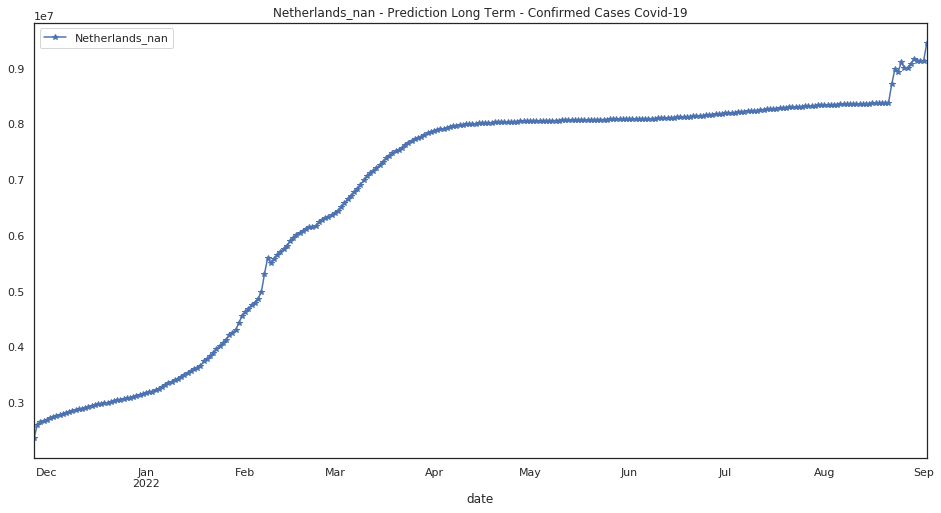

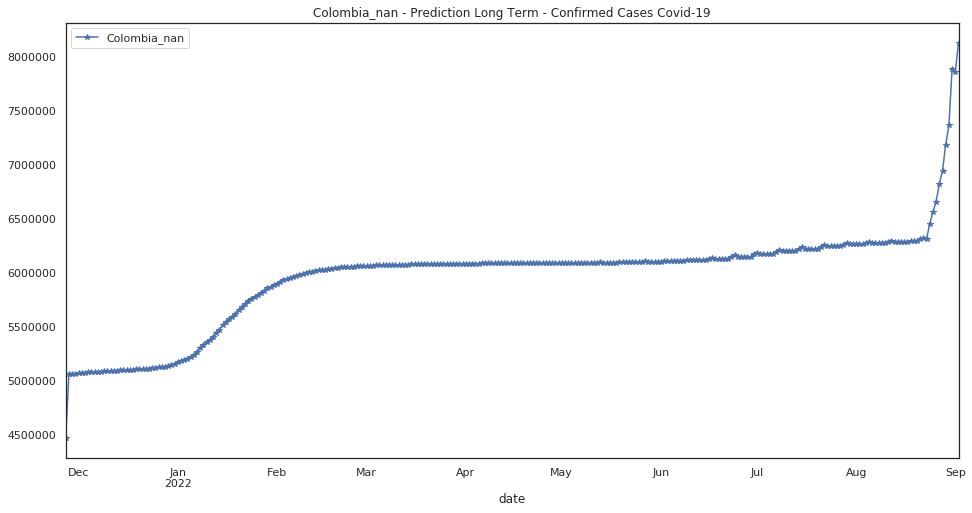

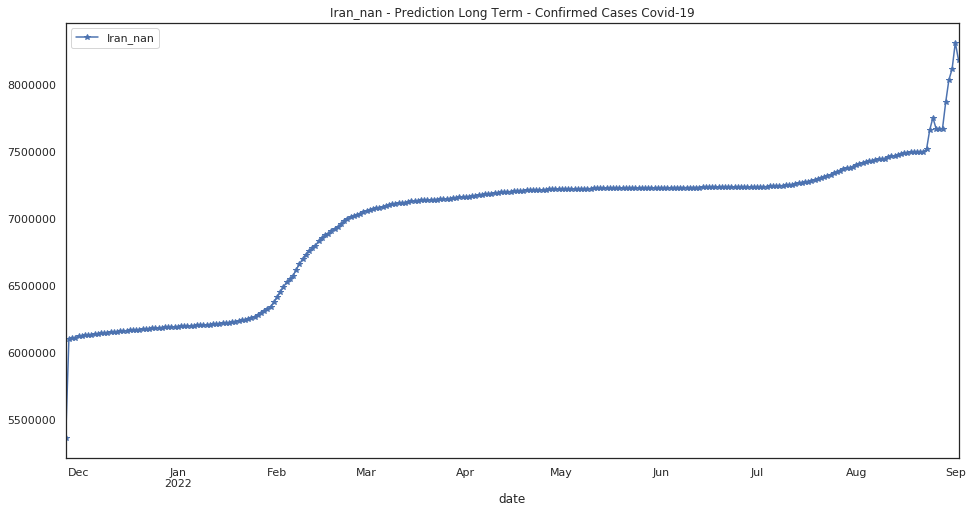

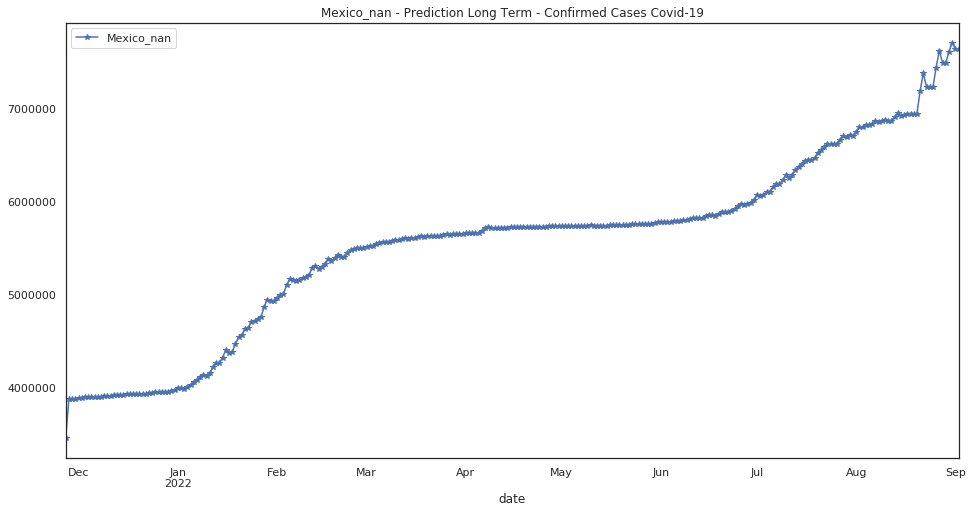

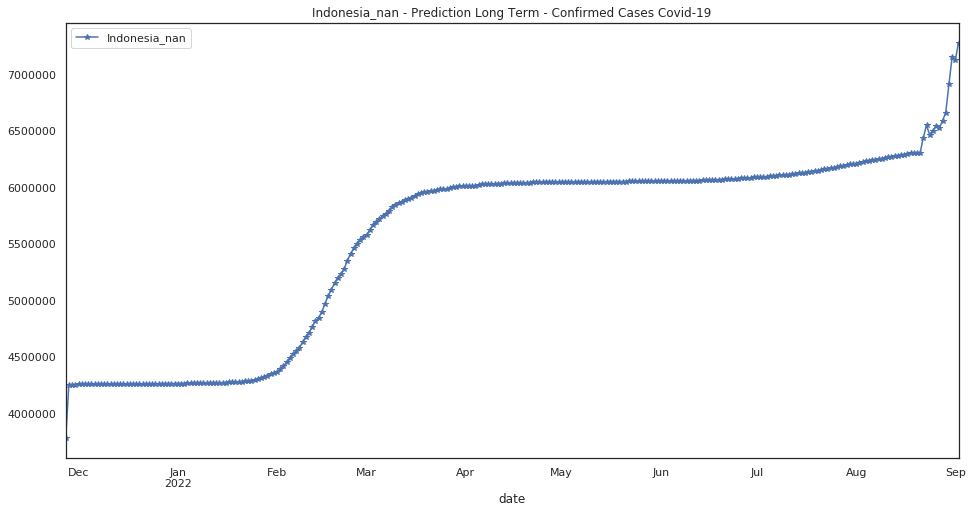

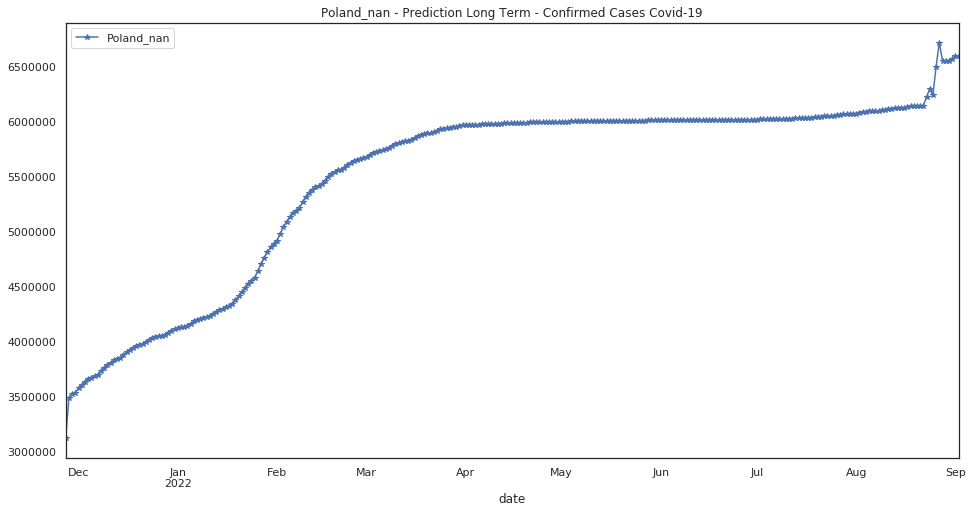

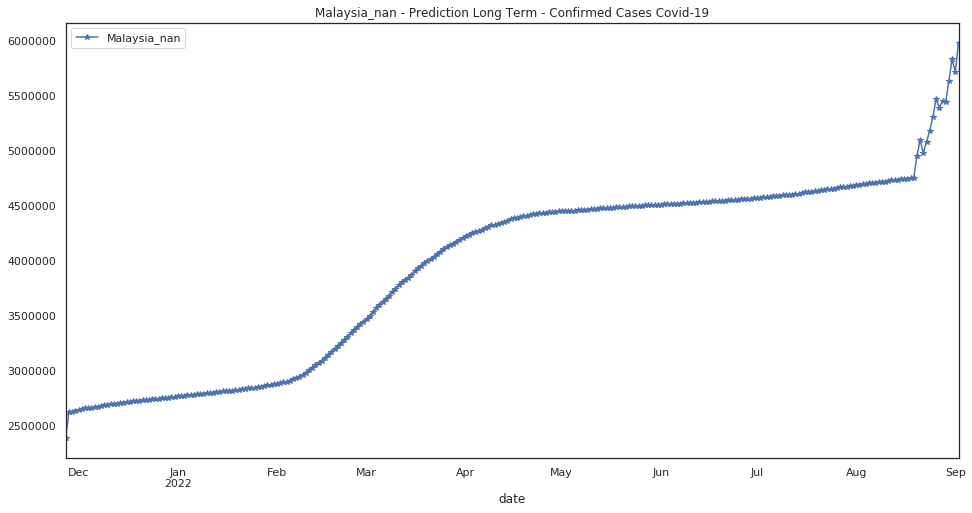

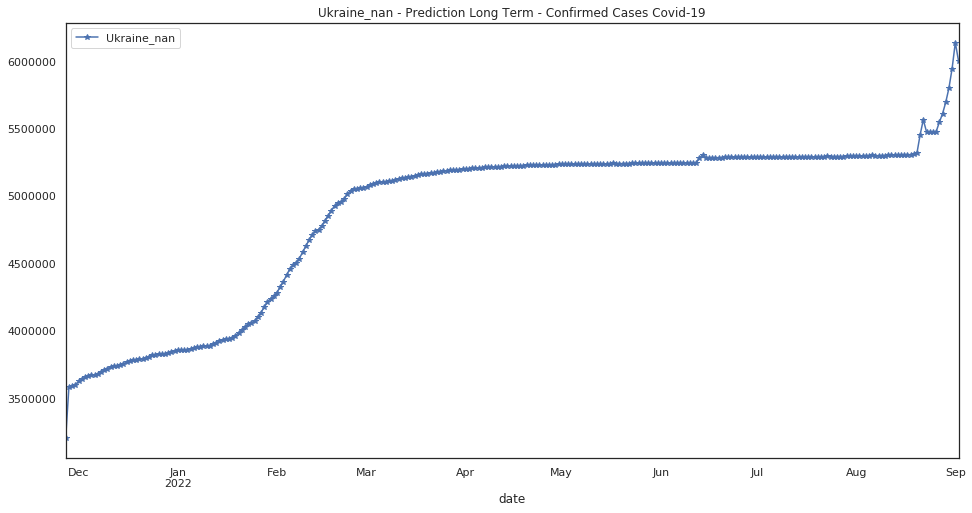

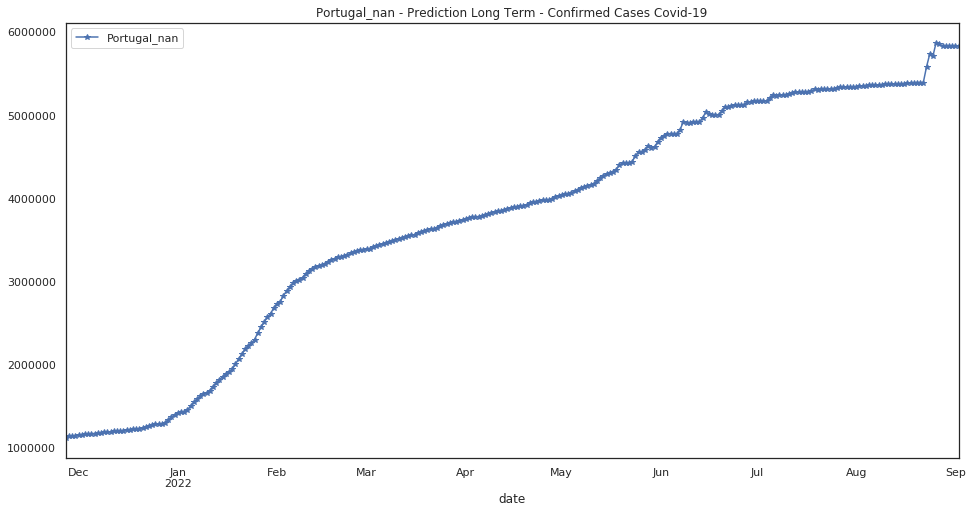

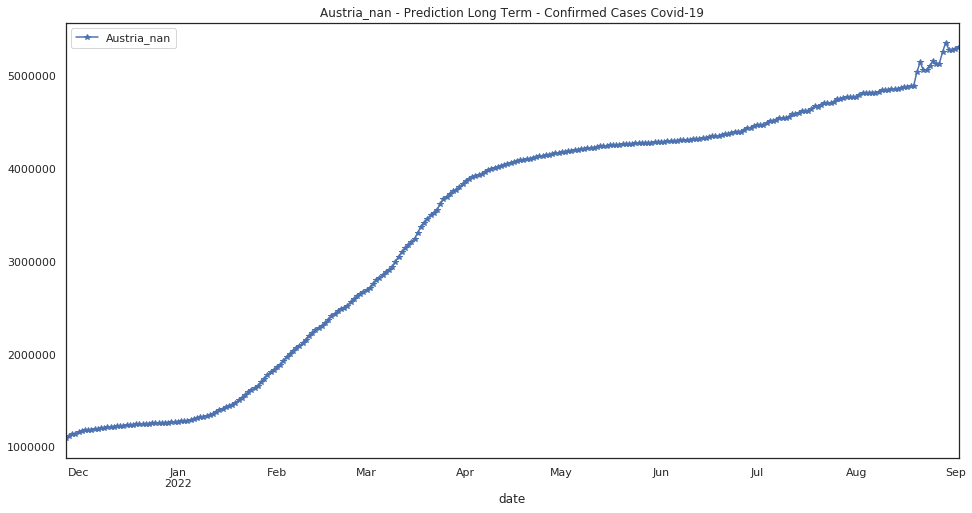

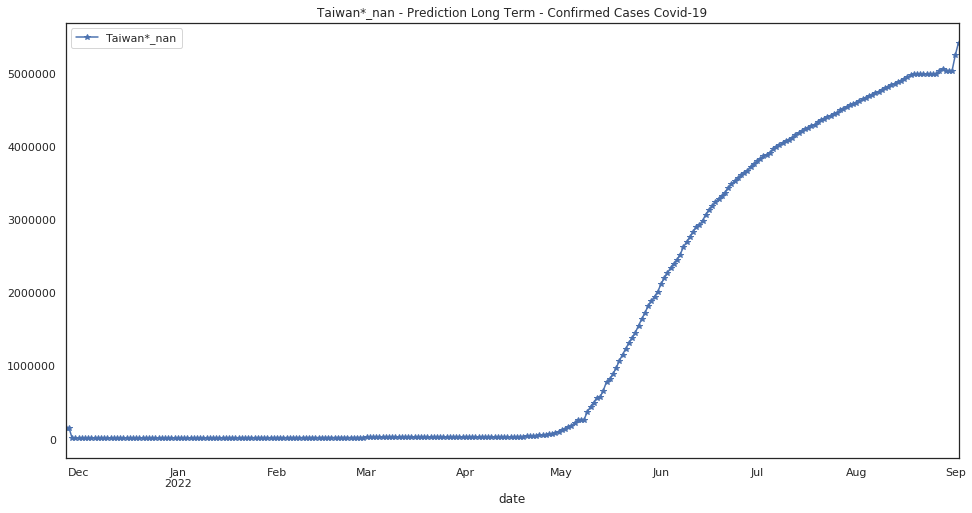

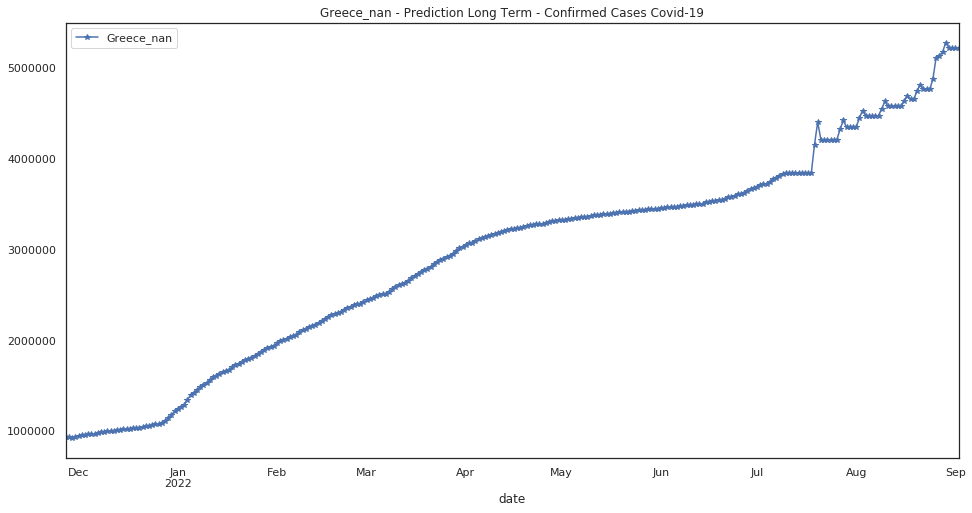

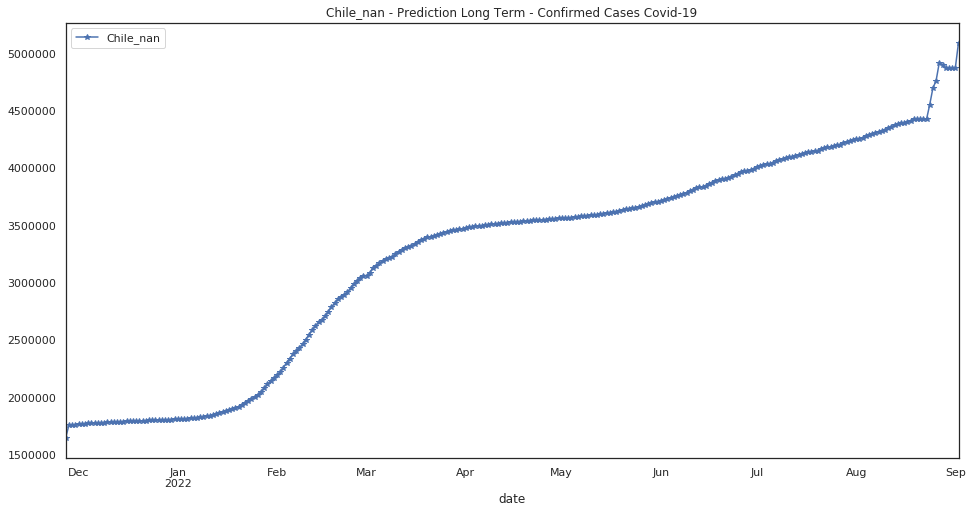

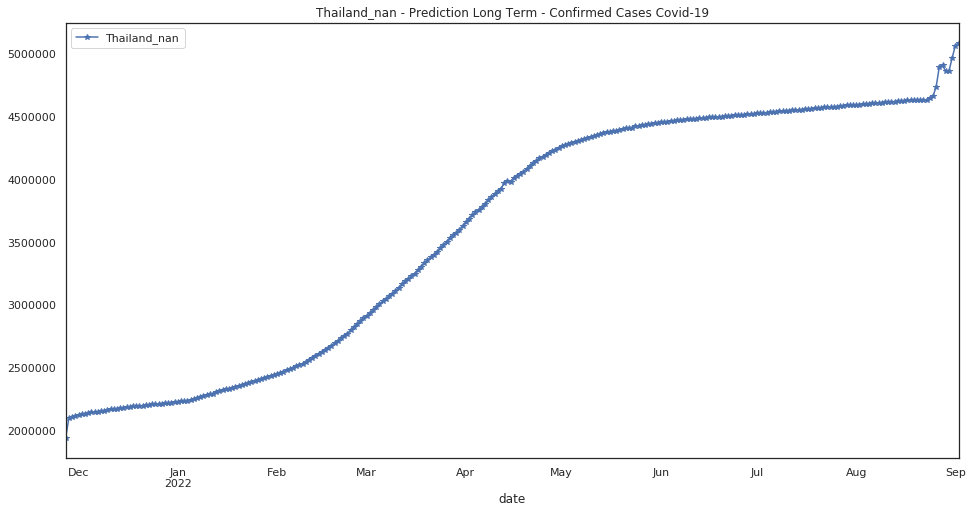

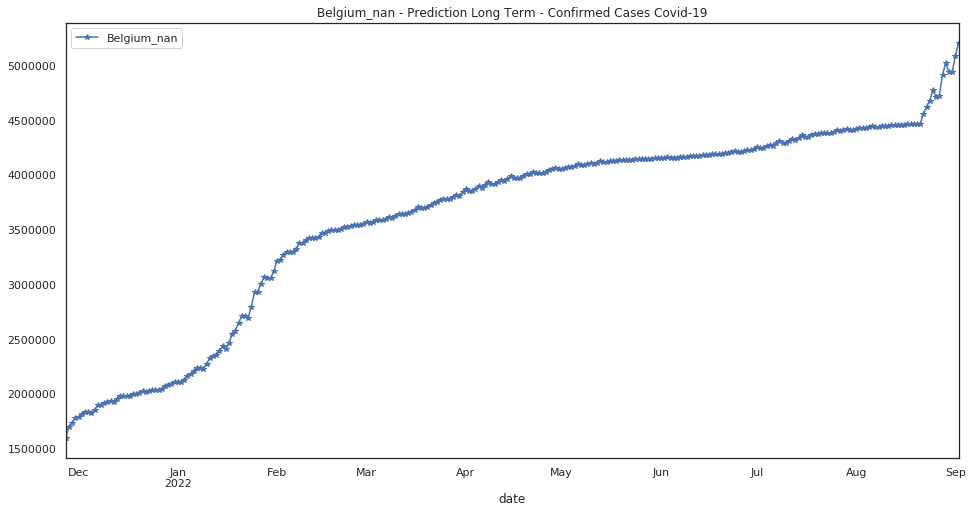

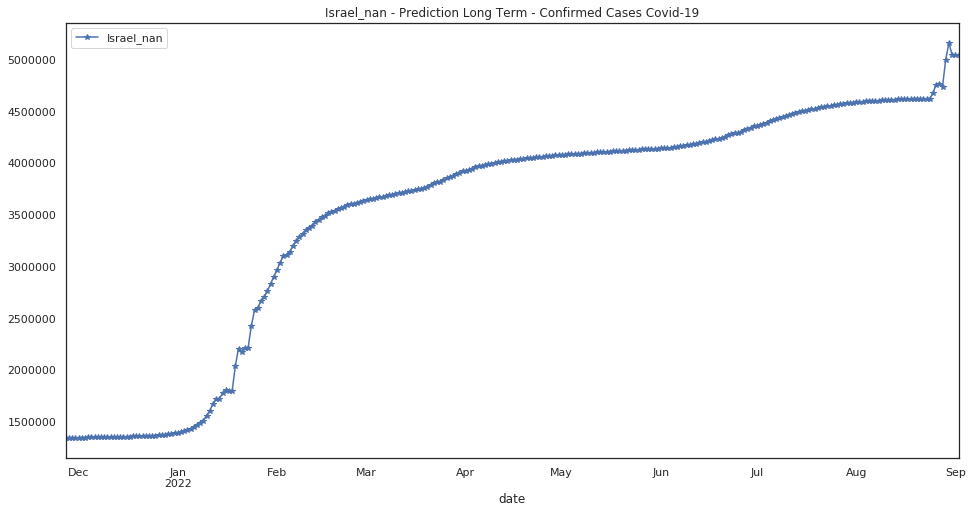

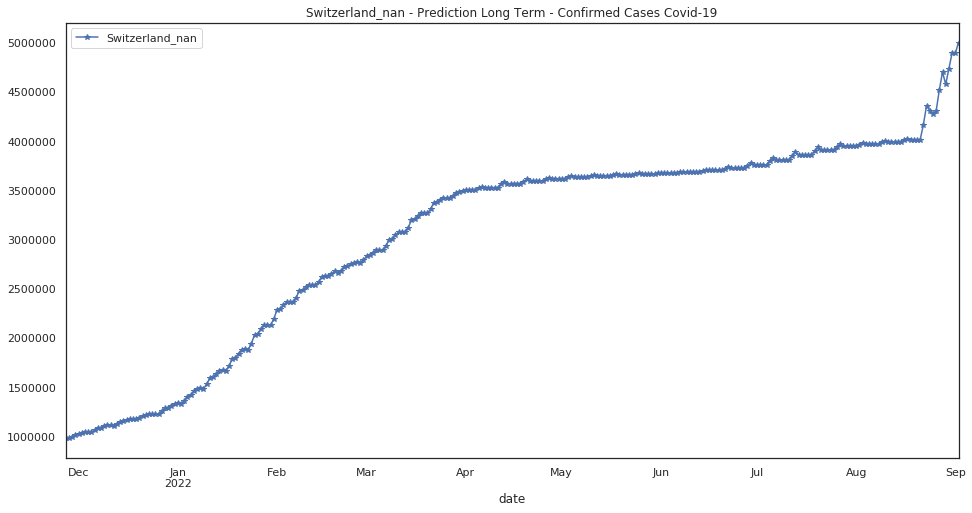

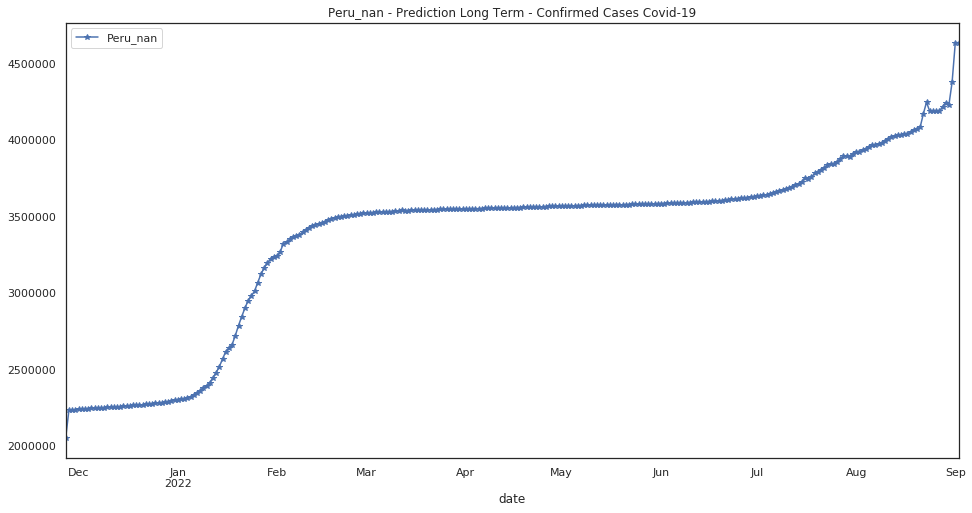

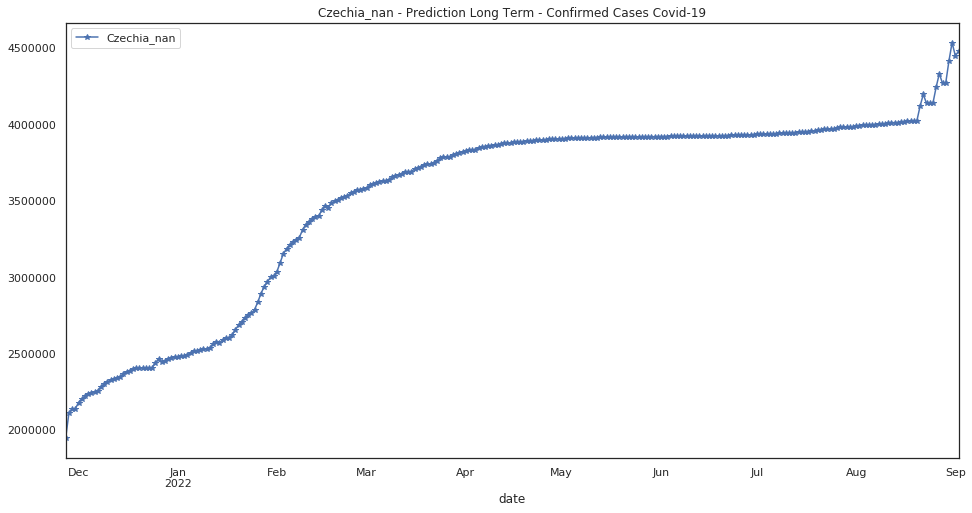

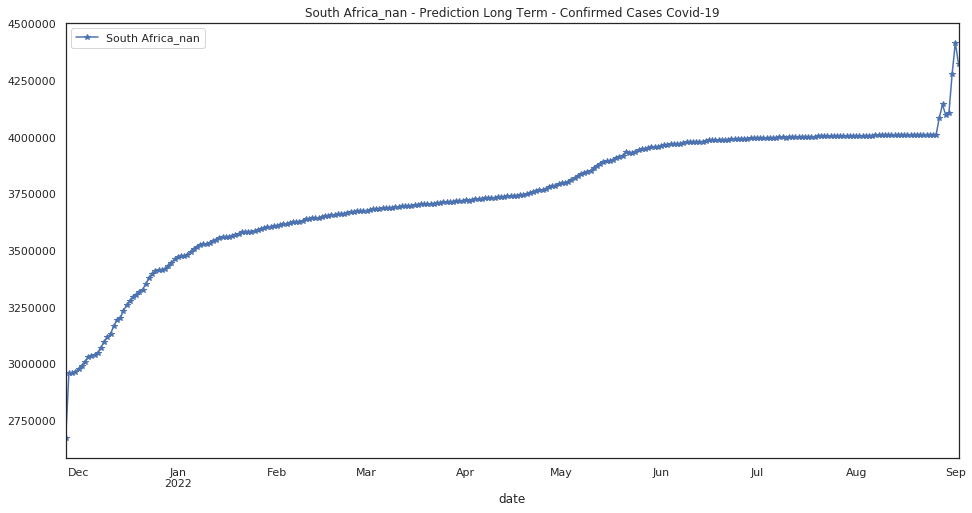

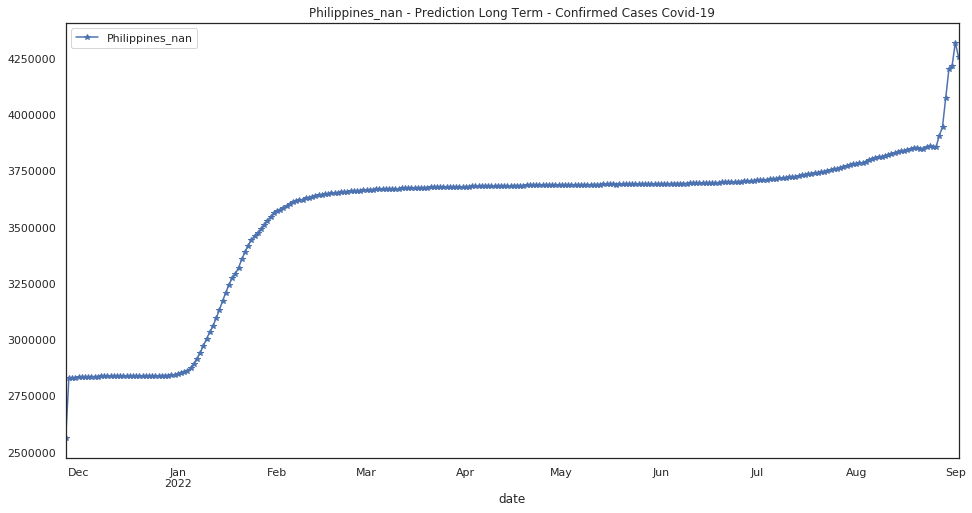

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

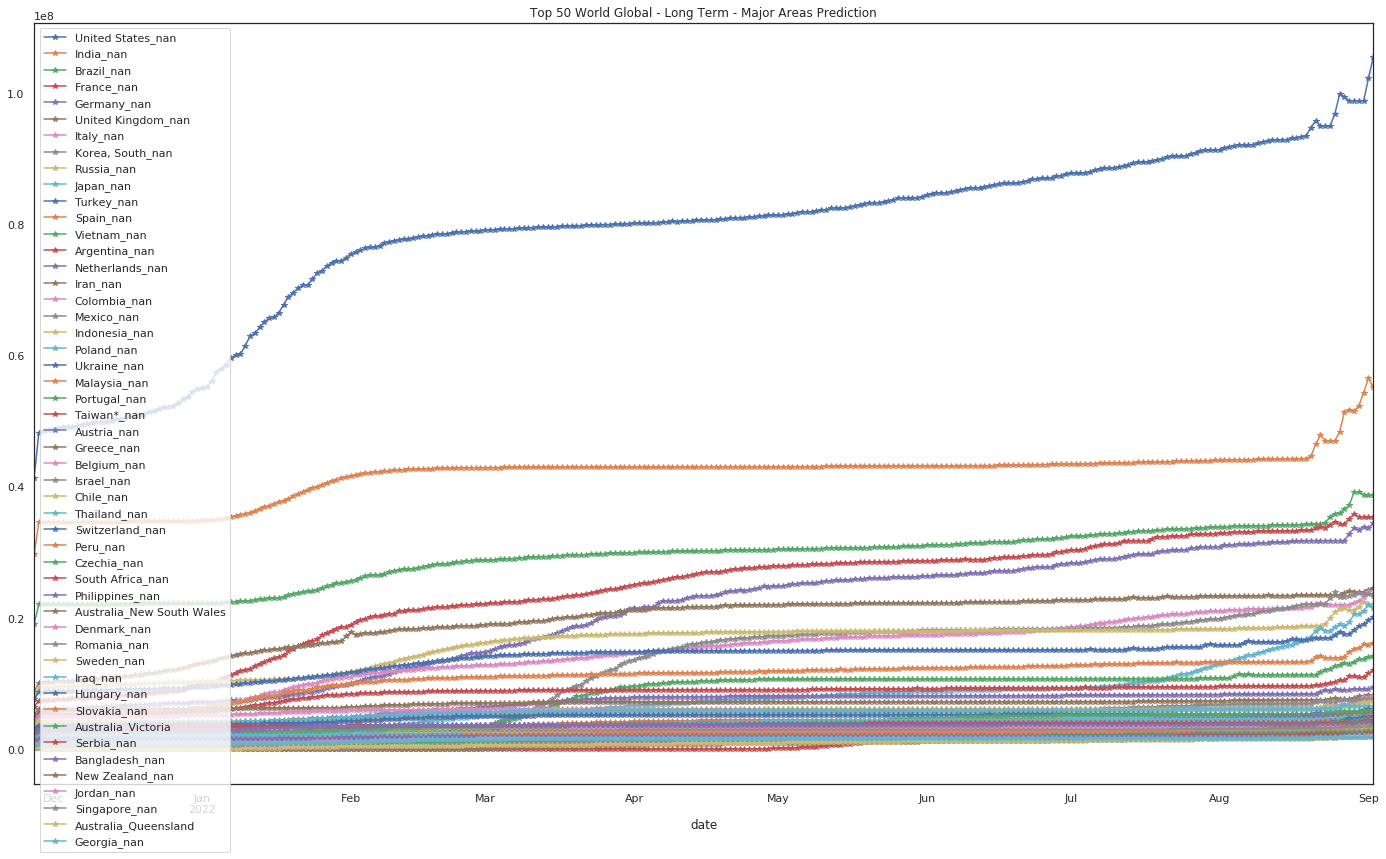

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

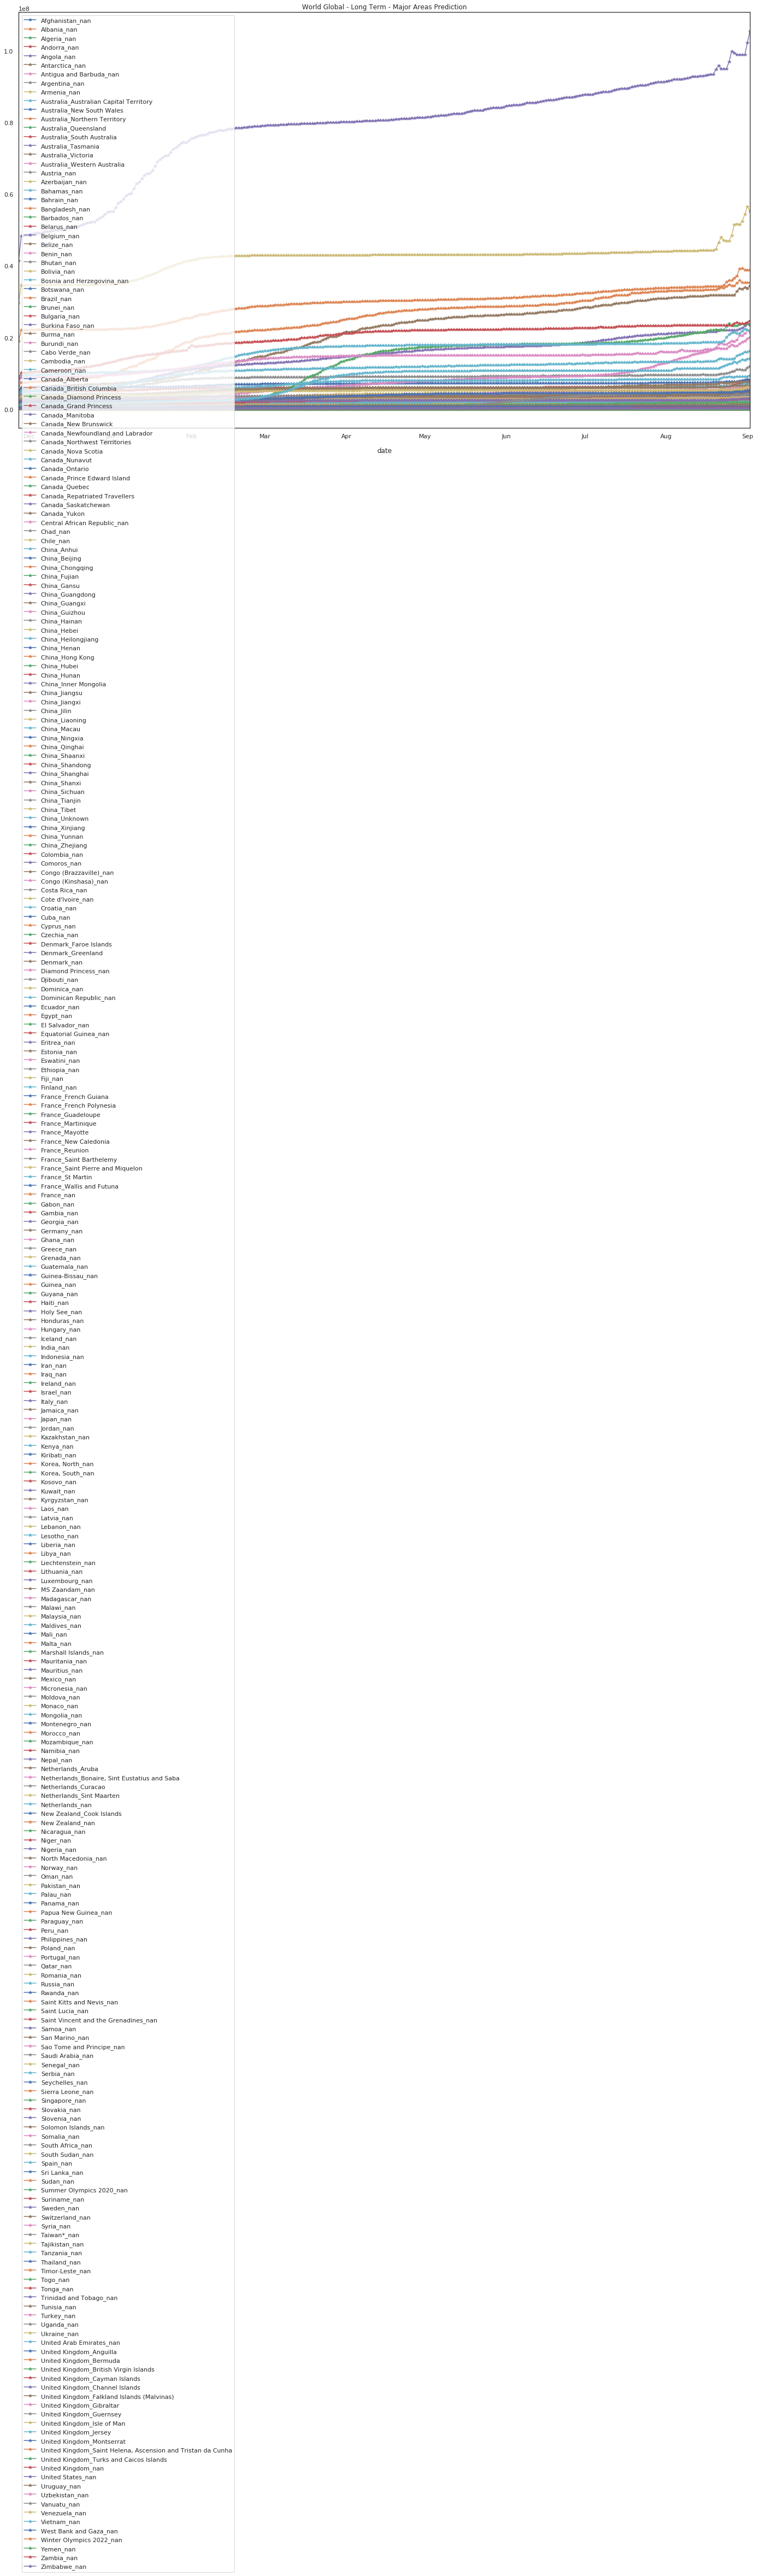

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2022-01-11         160717.0     223691.0     225202.0      27983.0   
2022-01-12         160743.0     225578.0     225798.0      28542.0   
2022-01-13         160836.0     227431.0     226374.0      28899.0   
2022-01-14         160865.0     229569.0     226961.0      29886.0   
2022-01-15         160918.0     231707.0     227474.0      29888.0   
2022-01-16         160954.0     233356.0     228032.0      29963.0   
2022-01-17         161053.0     234650.0     228697.0      29963.0   
2022-01-18         161172.0     237184.0     229479.0      29888.0   
2022-01-19         161264.0     239842.0     230750.0      29888.0   
2022-01-20         161492.0     242246.0     232242.0      31742.0   
2022-01-21         161664.0     244881.0     234016.0      32201.0   
2022-01-22         161720.0     247157.0     236127.0      33025.0   
2022-01-23         161862.0     248879.0     238198.0      33462.0   
2022-01-24         162059.0     249089.0     240330.0      33025.0   
2022-01-25         162351.0     249707.0     242735.0      33991.0   
2022-01-26         162748.0     251799.0     244872.0      34701.0   
2022-01-27         163048.0     253547.0     246962.0      35028.0   
2022-01-28         163172.0     255143.0     248841.0      35378.0   
2022-01-29         163450.0     255443.0     250587.0      35556.0   
2022-01-30         164117.0     256831.0     252112.0      35556.0   
2022-01-31         164748.0     259563.0     253492.0      35556.0   
2022-02-01         165402.0     259898.0     254926.0      35958.0   
2022-02-02         166087.0     262064.0     256363.0      35958.0   
2022-02-03         166621.0     262627.0     257420.0      36315.0   
2022-02-04         167243.0     264135.0     258427.0      36470.0   
2022-02-05         167580.0     264565.0     259294.0      36599.0   
2022-02-06         168097.0     265619.0     259768.0      36599.0   
2022-02-07         168779.0     266189.0     260280.0      36599.0   
2022-02-08         169528.0     266973.0     260926.0      36808.0   
2022-02-09         170327.0     267704.0     261567.0      36808.0   
...                     ...          ...          ...          ...   
2022-08-04         188824.0     316620.0     270097.0      45793.0   
2022-08-05         189147.0     317417.0     270227.0      45793.0   
2022-08-06         189242.0     318262.0     270337.0      45793.0   
2022-08-07         189572.0     318856.0     270445.0      45793.0   
2022-08-08         189782.0     319032.0     270547.0      45793.0   
2022-08-09         190065.0     319811.0     270664.0      45793.0   
2022-08-10         190303.0     320795.0     270774.0      45793.0   
2022-08-11         190603.0     321444.0     270903.0      45899.0   
2022-08-12         190808.0     322111.0     271052.0      45899.0   
2022-08-13         190957.0     322708.0     271195.0      45899.0   
2022-08-14         191173.0     323171.0     271327.0      45899.0   
2022-08-15         191449.0     323496.0     271454.0      45899.0   
2022-08-16         191596.0     324113.0     271566.0      45899.0   
2022-08-17         191846.0     324684.0     271660.0      45899.0   
2022-08-18         192124.0     325187.0     271742.0      45975.0   
2022-08-19         192367.0     326499.0     271836.0      45975.0   
2022-08-20         192410.0     326826.0     271854.0      45975.0   
2022-08-21         192444.0     326588.0     282147.0      47015.0   
2022-08-22         192449.0     334524.0     284485.0      48723.0   
2022-08-23         192460.0     337127.0     283323.0      49868.0   
2022-08-24         192468.0     335394.0     283330.0      49868.0   
2022-08-25         192481.0     347439.0     287469.0      50814.0   
2022-08-26         198515.0     351526.0     288552.0      53011.0   
2022-08-27         198370.0     348734.0     287955.0      53140.0   
2022-08-28

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      12       Australia_Queensland -27.469800  153.025100   
3      15         Australia_Victoria -37.813600  144.963100   
4      17                Austria_nan  47.516200   14.550100   
5      21             Bangladesh_nan  23.685000   90.356300   
6      24                Belgium_nan  50.833300    4.469936   
7      31                 Brazil_nan -14.235000  -51.925300   
8      60                  Chile_nan -35.675100  -71.543000   
9      95               Colombia_nan   4.570900  -74.297300   
10    104                Czechia_nan  49.817500   15.473000   
11    107                Denmark_nan  56.263900    9.501800   
12    133                 France_nan  46.227600    2.213700   
13    136                Georgia_nan  42.315400   43.356900   
14    137                Georgia_nan  42.315400   43.356900   
15    138                Germany_nan  51.165691   10.451526   
16    140                 Greece_nan  39.074200   21.824300   
17    150                Hungary_nan  47.162500   19.503300   
18    152                  India_nan  20.593684   78.962880   
19    153              Indonesia_nan  -0.789300  113.921300   
20    154                   Iran_nan  32.427908   53.688046   
21    155                   Iraq_nan  33.223191   43.679291   
22    157                 Israel_nan  31.046051   34.851612   
23    158                 Israel_nan  31.046051   34.851612   
24    159                  Italy_nan  41.871940   12.567380   
25    161                  Japan_nan  36.204824  138.252924   
26    162                 Jordan_nan  31.240000   36.510000   
27    167           Korea, South_nan  35.907757  127.766922   
28    184               Malaysia_nan   4.210484  101.975766   
29    191                 Mexico_nan  23.634500 -102.552800   
30    205            Netherlands_nan  52.132600    5.291300   
31    207            New Zealand_nan -40.900600  174.886000   
32    219                   Peru_nan  -9.190000  -75.015200   
33    220            Philippines_nan  12.879721  121.774017   
34    221                 Poland_nan  51.919400   19.145100   
35    222               Portugal_nan  39.399900   -8.224500   
36    224                Romania_nan  45.943200   24.966800   
37    225                 Russia_nan  61.524010  105.318756   
38    235                 Serbia_nan  44.016500   21.005900   
39    238              Singapore_nan   1.283300  103.833300   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-11-27 00:00:00  2021-11-28 00:00:00  2021-11-29 00:00:00  \
0             4698457.0            5325560.0            5326448.0   
1              211669.0             211792.0              81499.0   
2              143878.0             143882.0               2125.0   
3              244574.0             245429.0             120814.0   
4             1098811.0            1118256.0            1136218.0   
5             1490083.0            1575579.0            1575784.0   
6             1597931.0            1701633.0            1733786.0   
7            19034634.0           22081833.0           22085369.0   
8             1645368.0            1757077.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()